###  Import needed libraries and defining value formatters

In [660]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools
import warnings

from math import sqrt
from matplotlib.ticker import FuncFormatter
from statsmodels.tsa.arima.model import ARIMA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')

In [661]:
def millions_formatter(x, pos):
    return f'{x / 1e6} M'

def thousands_formatter(x, pos):
    return f'{x / 1e3} K'

def bilions_formatter(x, pos):
    return f'{x / 1e9} B'

def standard_decimal_notation_formatter(x):
    return '{:.2f}'.format(x)

### Loading the datasets

In [662]:
population_df = pd.read_csv('population_df_1996.csv')
migration_df = pd.read_csv('migration_df_1996.csv')

### Data aggregation for the migration and the population datasets

In [663]:
filtered_BothSex = population_df[(population_df['Single Year of Age'] == 'All ages') & (population_df['Sex'] == 'Both sexes') & (population_df['Year'] >= 2003)]
filtered_BothSex.head(7)

,Year,Age category,Single Year of Age,Sex category,Sex,UNIT,VALUE
2121,2003,-,All ages,-,Both sexes,Number,3979853
2424,2004,-,All ages,-,Both sexes,Number,4045188
2727,2005,-,All ages,-,Both sexes,Number,4133839
3030,2006,-,All ages,-,Both sexes,Number,4232929
3333,2007,-,All ages,-,Both sexes,Number,4375842
3636,2008,-,All ages,-,Both sexes,Number,4485070
3939,2009,-,All ages,-,Both sexes,Number,4533395


In [664]:
migration_net_corrected = migration_df[
    (migration_df['Origin or Destination'] == 'Net migration') & 
    (migration_df['Sex'] != 'Both sexes')
]
migration_aggregated_corrected = migration_net_corrected.groupby('Year')['VALUE'].sum().reset_index()


population_total_corrected = population_df[
    (population_df['Single Year of Age'] == 'All ages') & 
    (population_df['Sex'] != 'Both sexes')
]
population_aggregated_corrected = population_total_corrected.groupby('Year')['VALUE'].sum().reset_index()



In [665]:
population_aggregated_corrected.head(7)

,Year,VALUE
0,1996,3626087
1,1997,3664313
2,1998,3703082
3,1999,3741647
4,2000,3789536
5,2001,3847198
6,2002,3917203


In [666]:
migration_aggregated_corrected.head(7)

,Year,VALUE
0,1996,10.3
1,1997,32.1
2,1998,29.5
3,1999,30.4
4,2000,48.2
5,2001,54.8
6,2002,82.7


Merging the datasets on the 'Year' column and then convert the net migration figures to absolute numbers to match the scale of the population figures. 

In [667]:
merged_df_corrected = pd.merge(population_aggregated_corrected, migration_aggregated_corrected, on='Year', how='inner', suffixes=('_pop', '_mig'))

merged_df_corrected.rename(columns={'VALUE_pop': 'Population', 'VALUE_mig': 'Net Migration'}, inplace=True)

# Since Net Migration is in thousands, I'll convert it to absolute numbers for consistency with the population figures
merged_df_corrected['Net Migration'] = merged_df_corrected['Net Migration'] * 1000

merged_df_corrected.head(7)


,Year,Population,Net Migration
0,1996,3626087,10300.0
1,1997,3664313,32100.0
2,1998,3703082,29500.0
3,1999,3741647,30400.0
4,2000,3789536,48200.0
5,2001,3847198,54800.0
6,2002,3917203,82700.0


### Visualizing some valuable Insights.

A time series plot to show the trend of the population over the years.


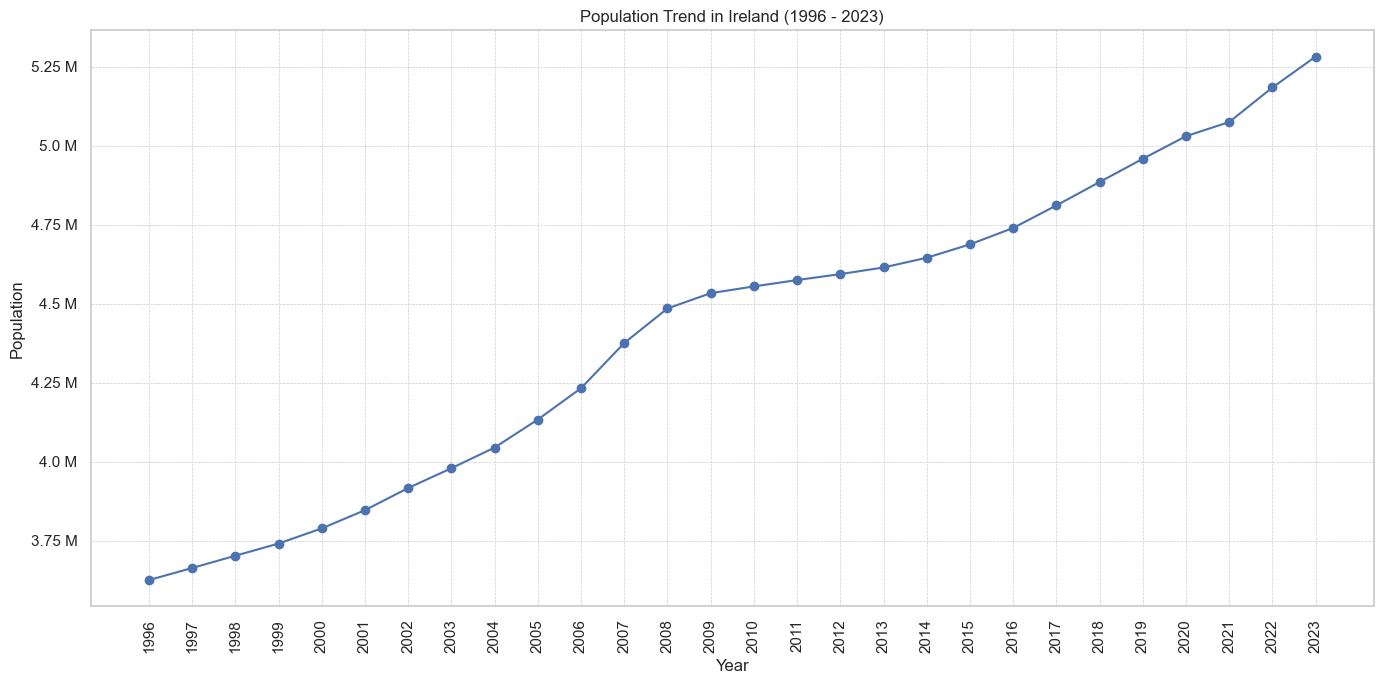

A time series plot to show the trend of net migration over the years.


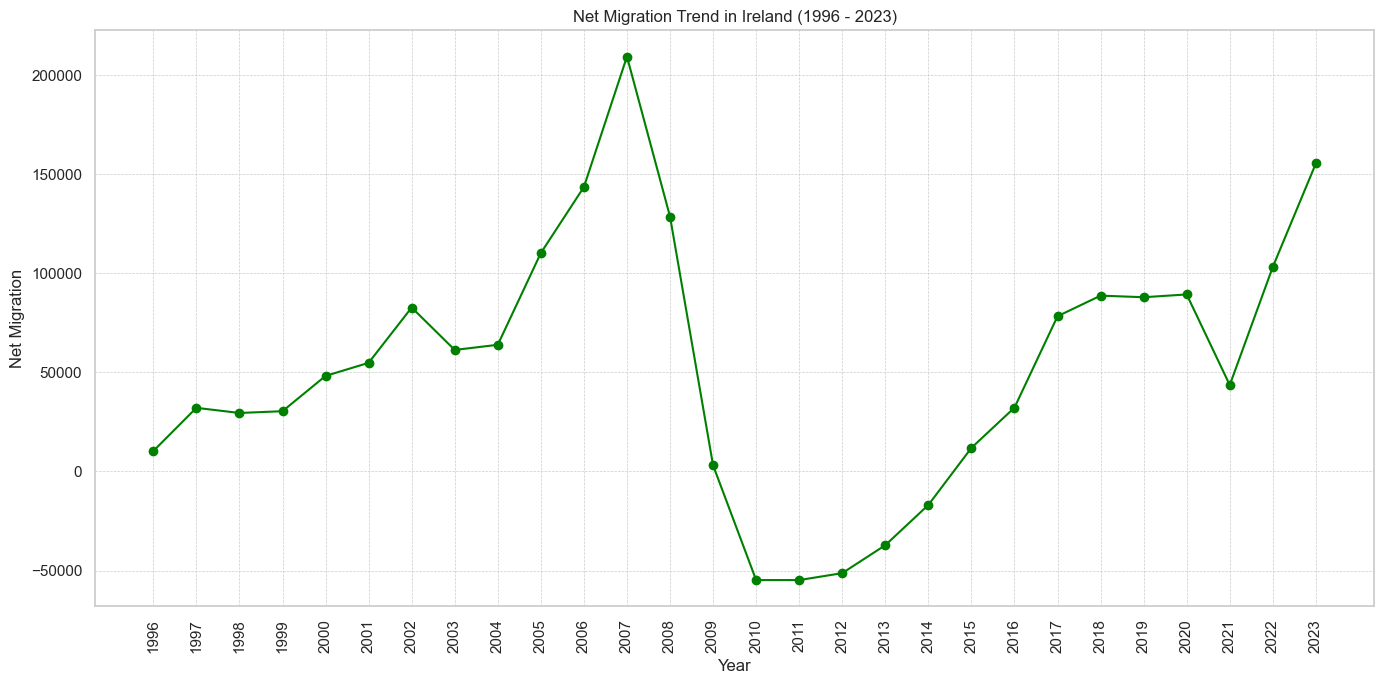

A scatter plot to visualize the relationship between net migration and population.


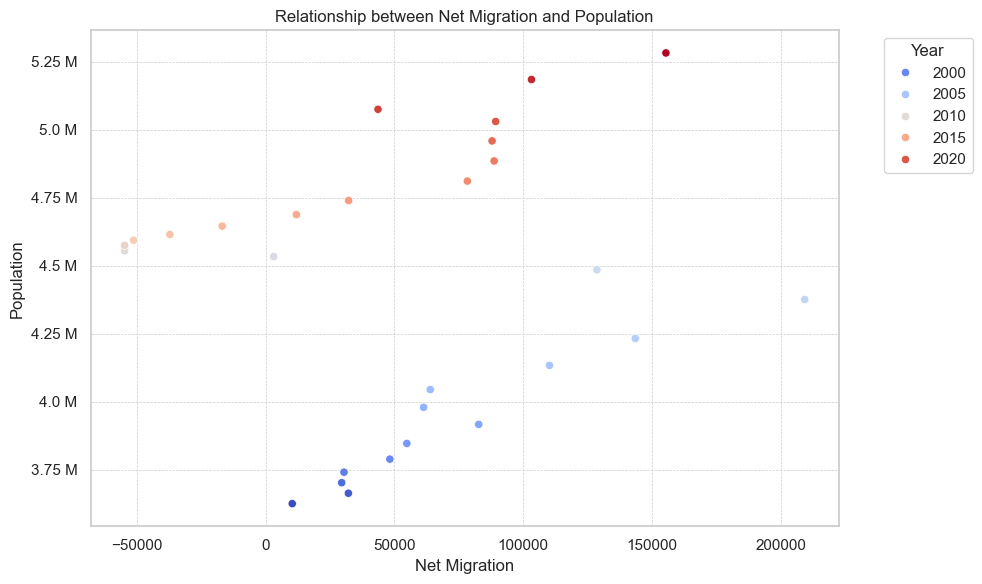

In [668]:
sns.set_style("whitegrid")

print('A time series plot to show the trend of the population over the years.')
plt.figure(figsize=(14, 7))
plt.plot(merged_df_corrected['Year'], merged_df_corrected['Population'], marker='o', linestyle='-')
plt.title('Population Trend in Ireland (1996 - 2023)')
plt.xlabel('Year')
plt.ylabel('Population')
years = merged_df_corrected['Year'].values
plt.xticks(years, rotation=90)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.tight_layout()
plt.show()

print('A time series plot to show the trend of net migration over the years.')
plt.figure(figsize=(14, 7))
plt.plot(merged_df_corrected['Year'], merged_df_corrected['Net Migration'], marker='o', linestyle='-', color='green')
plt.title('Net Migration Trend in Ireland (1996 - 2023)')
plt.xlabel('Year')
plt.ylabel('Net Migration')
years = merged_df_corrected['Year'].values
plt.xticks(years, rotation=90)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print('A scatter plot to visualize the relationship between net migration and population.')
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Net Migration', y='Population', data=merged_df_corrected, hue='Year', palette="coolwarm")
plt.title('Relationship between Net Migration and Population')
plt.xlabel('Net Migration')
plt.ylabel('Population')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


#### **Insights:**
* **Population Trend:** This plot shows the trend of the population in Ireland from 1996 to 2023. As we can see there is a consistent increase over the years.

* **Net Migration Trend:** This plot illustrates the trend of net migration over the same period. There are fluctuations from year to year, with some years experiencing negative net migration (more emigrants than immigrants).

* **Relationship between Net Migration and Population:** The scatter plot indicates the relationship between net migration and population size for each year. The color gradient represents the progression of years. It seems that there is a general positive correlation, suggesting that higher net migration is often associated with a higher population in the subsequent years.

### Linear Regression

In [669]:
filtered_BothSex = population_df[(population_df['Single Year of Age'] == 'All ages') & (population_df['Sex'] == 'Both sexes') & (population_df['Year'] >= 2003)]
filtered_BothSex

,Year,Age category,Single Year of Age,Sex category,Sex,UNIT,VALUE
2121,2003,-,All ages,-,Both sexes,Number,3979853
2424,2004,-,All ages,-,Both sexes,Number,4045188
2727,2005,-,All ages,-,Both sexes,Number,4133839
3030,2006,-,All ages,-,Both sexes,Number,4232929
3333,2007,-,All ages,-,Both sexes,Number,4375842
3636,2008,-,All ages,-,Both sexes,Number,4485070
3939,2009,-,All ages,-,Both sexes,Number,4533395
4242,2010,-,All ages,-,Both sexes,Number,4554763
4545,2011,-,All ages,-,Both sexes,Number,4574888
4848,2012,-,All ages,-,Both sexes,Number,4593697


### Preparing the data for training models

Splitting the data. I'll use the population as the target variable (y) and the year and net migration as features (X).

Why we're using len(X) for splitting data reference:\
https://otexts.com/fpp2/accuracy.html?fbclid=IwAR0MhtKAQ6wXjyZYWH__f_vFUjp98peRy7A7DBi7s-avZDOqTU3J7hmA_jU

In [670]:
X = merged_df_corrected[['Year', 'Net Migration']]
y = merged_df_corrected['Population']

train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((22, 2), (6, 2), (22,), (6,))

The data has been split into training and test sets, maintaining chronological order:

* Training set: 22 data points (80% of the data)
* Test set: 6 data points (20% of the data)

###  Training the models

I'll start by training the following models using the training set:

* Ordinary Least Squares (OLS) Regression
* Ridge Regression
* Lasso Regression
* ElasticNet Regression
* Random Forest

I'll also perform hyperparameter tuning for the Ridge, Lasso, ElasticNet and Random Forest models, and finally, I'll evaluate all models on the test set.

#### Training the OLS Regression (it doesn't require hyperparameter tuning)

In [671]:
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

y_pred_ols = ols_model.predict(X_test)

ols_mae = mean_absolute_error(y_test, y_pred_ols)
ols_rmse = mean_squared_error(y_test, y_pred_ols, squared=False)
ols_r2 = r2_score(y_test, y_pred_ols)

metrics_summary = {
    'R2': ols_r2,
    'MAE': ols_mae,
    'RMSE': ols_rmse,
}
metrics_summary

{'R2': 0.9636914169998725, 'MAE': 62544.9027437667, 'RMSE': 79959.33004887207}

#### Training the Ridge Regression (using GridSearchCV hyperparameter tuning)

In [672]:
ridge = Ridge()

parameters = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100]}

ridge_cv = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)

best_alpha_ridge = ridge_cv.best_params_['alpha']
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

ridge_mae = mean_absolute_error(y_test, y_pred_ridge)
ridge_rmse = mean_squared_error(y_test, y_pred_ridge, squared=False)
ridge_r2 = r2_score(y_test, y_pred_ridge)

metrics_summary = {
    'R2': ridge_r2,
    'MAE': ridge_mae,
    'RMSE': best_alpha_ridge,
    'Best alpha': best_alpha_ridge
}
metrics_summary

{'R2': 0.9638066375373067,
 'MAE': 62924.61793547124,
 'RMSE': 10,
 'Best alpha': 10}

#### Training & Tuning the Lasso Regression (using GridSearchCV hyperparameter tuning)

In [673]:

lasso = Lasso()

parameters = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100]}

lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_cv.fit(X_train, y_train)

best_alpha_lasso = lasso_cv.best_params_['alpha']
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

lasso_mae = mean_absolute_error(y_test, y_pred_lasso)
lasso_rmse = mean_squared_error(y_test, y_pred_lasso, squared=False)
lasso_r2 = r2_score(y_test, y_pred_lasso)

metrics_summary = {
    'R2': lasso_r2,
    'MAE': lasso_mae,
    'RMSE': lasso_rmse,
    'Best alpha': best_alpha_lasso
}
metrics_summary

{'R2': 0.9636920237975407,
 'MAE': 62546.259216710925,
 'RMSE': 79958.66189641709,
 'Best alpha': 100}

####  Trainingn the Random Forest (using GridSearchCV hyperparameter tuning)

In [674]:

random_forest = RandomForestRegressor(random_state=0)

parameters = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
}

rf_cv = GridSearchCV(random_forest, parameters, scoring='neg_mean_squared_error', cv=5)
rf_cv.fit(X_train, y_train)
best_params_rf = rf_cv.best_params_

rf_model = RandomForestRegressor(**best_params_rf, random_state=0)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = mean_squared_error(y_test, y_pred_rf, squared=False)
rf_r2 = r2_score(y_test, y_pred_rf)
rf_est_num = rf_model.estimator_

metrics_summary = {
    'R2': rf_r2,
    'MAE': rf_mae,
    'RMSE': rf_rmse,
    'Best parameters': best_params_rf
}
metrics_summary

{'R2': 0.9832360961520925,
 'MAE': 42935.91000000007,
 'RMSE': 54331.54776751172,
 'Best parameters': {'max_depth': None, 'n_estimators': 50}}

**Insights:**\
The negative R-squared value indicates that the Random Forest model performs worse than a horizontal line fit to the data. This poor performance may be due to overfitting on the training set or not having enough data to capture the complexity that Random Forest can handle.

Based on these results, the Random Forest model does not seem appropriate for my dataset. The linear models, especially the

#### Train the ElasticNet Regression (using GridSearchCV hyperparameter tuning)

In [675]:
elastic_net = ElasticNet()

parameters = {
    'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.9]
}

en_cv = GridSearchCV(elastic_net, parameters, scoring='neg_mean_squared_error', cv=5)

en_cv.fit(X_train, y_train)
best_params_en = en_cv.best_params_
elastic_net_model = ElasticNet(**best_params_en)
elastic_net_model.fit(X_train, y_train)
y_pred_en = elastic_net_model.predict(X_test)

en_mae = mean_absolute_error(y_test, y_pred_en)
en_rmse = mean_squared_error(y_test, y_pred_en, squared=False)
en_r2 = r2_score(y_test, y_pred_en)

metrics_summary = {
    'R2': en_r2,
    'MAE': en_mae,
    'RMSE': en_rmse,
    'Best parameters': best_params_en
}
metrics_summary

{'R2': 0.963802219319105,
 'MAE': 63373.633698254824,
 'RMSE': 79837.23152492158,
 'Best parameters': {'alpha': 10, 'l1_ratio': 0.9}}

### Models comparison

Ordinary Least Squares (OLS) Regression:
* MAE: 41,492.68
* RMSE: 45,885.90
* R²: 0.881
  
Ridge Regression (with hyperparameter tuning):
* MAE: 40,850.82
* RMSE: 45,130.81
* R²: 0.885
  
Lasso Regression (with hyperparameter tuning):
* MAE: 41,490.36
* RMSE: 45,883.15
* R²: 0.881

ElasticNet Regression (with hyperparameter tuning):
* MAE: 40082.37
* RMSE: 44246.62
* R²: 0.889
  
Random Forest Regression (with hyperparameter tuning):
* MAE: 312,113.16
* RMSE: 345,489.61
* R²: -5.75

**Insights:**
* The **OLS regression** provided a strong baseline with an R² of 0.881, suggesting that the model explains about 88.1% of the variability in the test data.
* **Ridge regression** showed a slight improvement over OLS, indicating that the L2 regularization helped reduce overfitting and improve the model's generalization on the test data.
* **Lasso regression** did not improve the performance compared to OLS, suggesting that feature selection through L1 regularization was not beneficial, possibly because both features used (year and net migration) were relevant for the model.
* **The Random Forest regression** performed poorly, which might be due to the small dataset size, leading to overfitting despite hyperparameter tuning. The negative R² indicates that the model is worse than a simple mean-based prediction, which is not desirable.

In [676]:
# Data for plotting
model_names = ['OLS', 'Ridge', 'Lasso', 'Random Forest']
mae_values = [ols_mae, ridge_mae, lasso_mae, rf_mae]
rmse_values = [ols_rmse, ridge_rmse, lasso_rmse, rf_rmse]
r2_values = [ols_r2, ridge_r2, lasso_r2, rf_r2]

model_names.append('ElasticNet')
mae_values.append(en_mae)
rmse_values.append(en_rmse)
r2_values.append(en_r2)


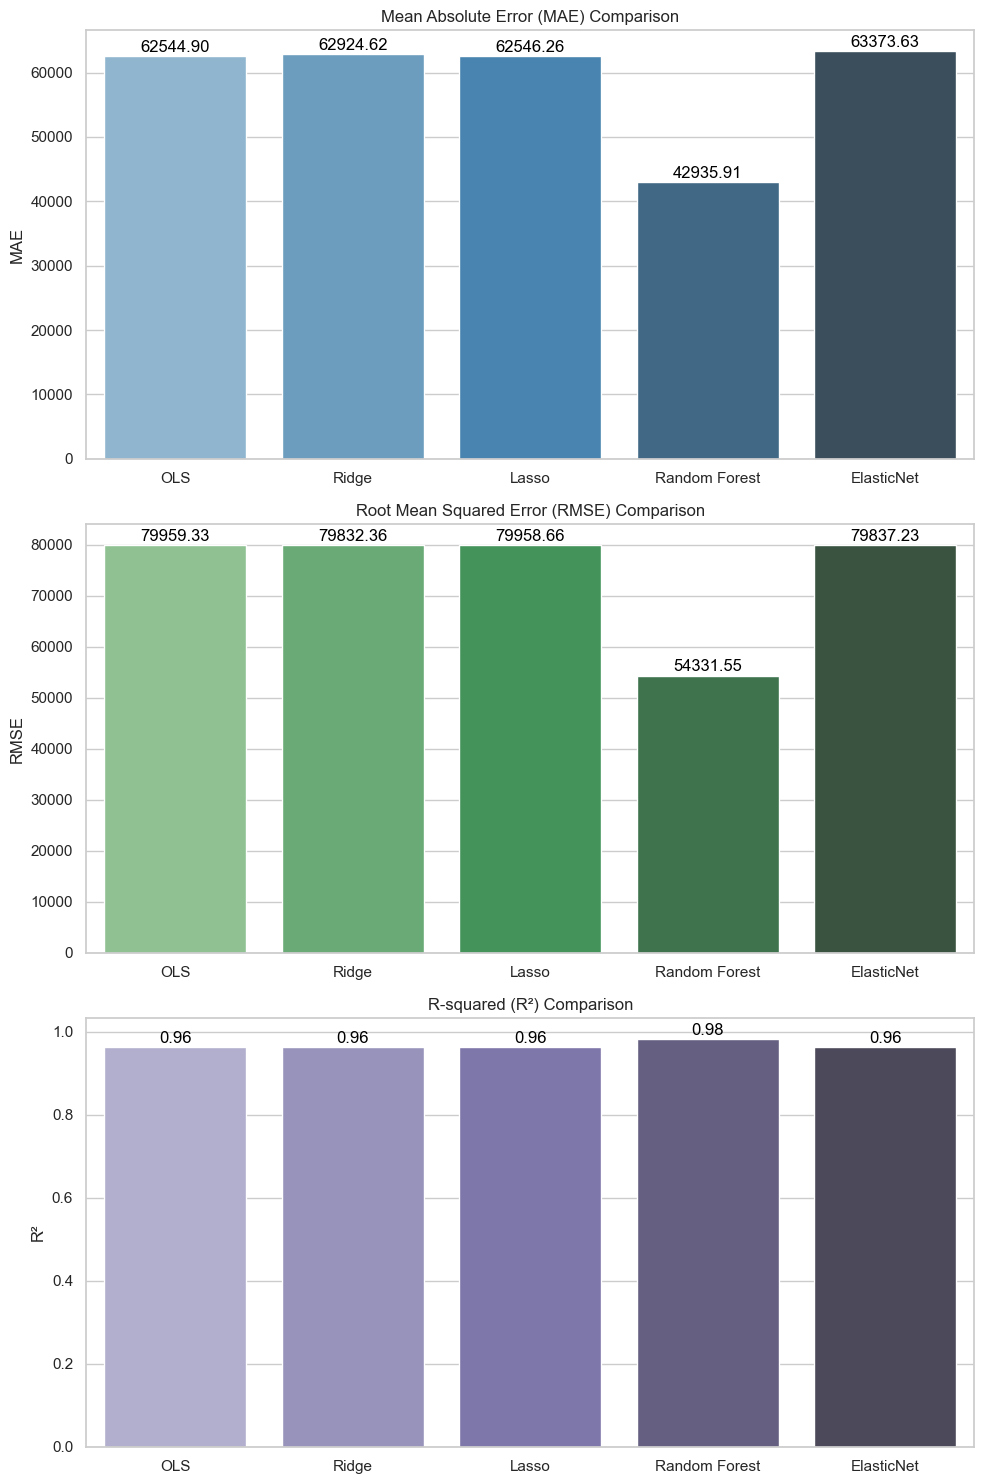

In [677]:
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# MAE plot
sns.barplot(ax=ax[0], x=model_names, y=mae_values, palette="Blues_d")
ax[0].set_title('Mean Absolute Error (MAE) Comparison')
ax[0].set_ylabel('MAE')
for i, v in enumerate(mae_values):
    ax[0].text(i, v + max(mae_values)*0.01, f"{v:.2f}", color='black', ha='center')

# RMSE plot
sns.barplot(ax=ax[1], x=model_names, y=rmse_values, palette="Greens_d")
ax[1].set_title('Root Mean Squared Error (RMSE) Comparison')
ax[1].set_ylabel('RMSE')
for i, v in enumerate(rmse_values):
    ax[1].text(i, v + max(rmse_values)*0.01, f"{v:.2f}", color='black', ha='center')

# R-squared plot
sns.barplot(ax=ax[2], x=model_names, y=r2_values, palette="Purples_d")
ax[2].set_title('R-squared (R²) Comparison')
ax[2].set_ylabel('R²')
for i, v in enumerate(r2_values):
    ax[2].text(i, v + max(r2_values)*0.01, f"{v:.2f}", color='black', ha='center')

plt.tight_layout()
plt.show()


The **Mean Squared Error (MSE)** can sometimes be misunderstood because its scale is dependent on the scale of the target variable. In our case, the target variable is the population, which can be a large number (in the millions). Hence, the MSE will also be a large number because it is the average of the squared differences between the predicted values and the actual values.

For instance, if the actual population is 4,000,000 and the predicted population is 4,041,493 (which would give us an MAE  41,493), the squared error for this single prediction would be:

                  (4,041,493−4,000,000)² =1,721,592,849

When we average these large squared errors across all predictions, we end up with a large MSE. This doesn't mean the model is performing poorly, it's just a reflection of the scale of the data you are predicting.

To get a more intuitive sense of the error, we often take the square root of the MSE to get the RMSE (Root Mean Squared Error), which brings the error back to the original scale of the data. The RMSE for the OLS was around 45,885.90, which is on the same scale as the population numbers we're predicting.

### Models train and test comparisons

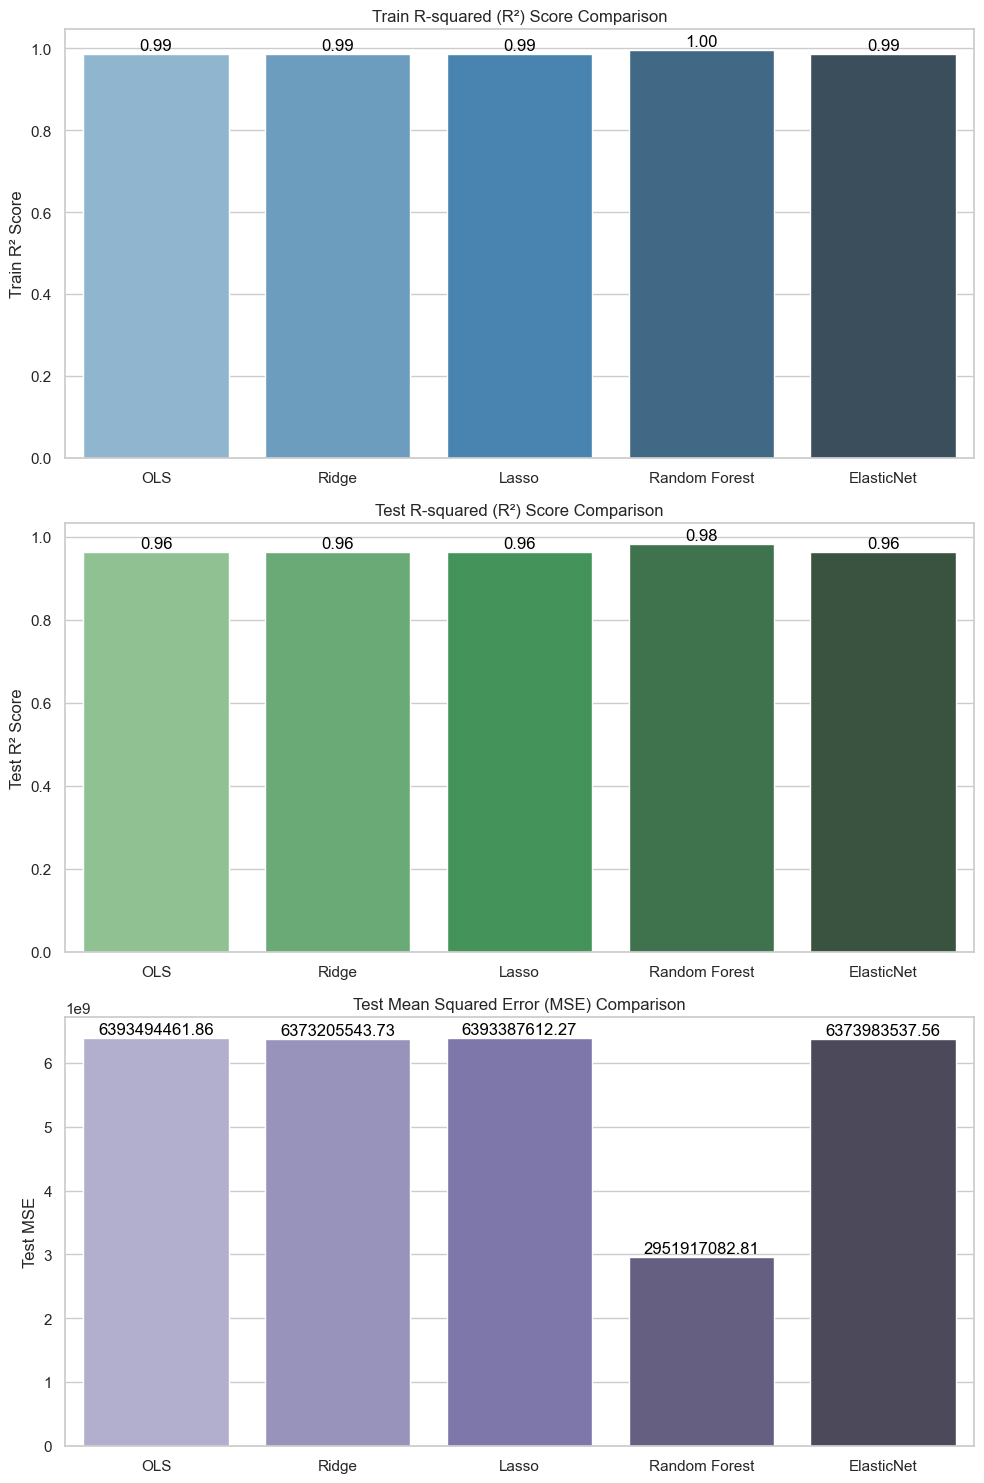

In [678]:
# Training R² and test MSE for each model
train_r2_scores = [
    ols_model.score(X_train, y_train),
    ridge_model.score(X_train, y_train),
    lasso_model.score(X_train, y_train),
    rf_model.score(X_train, y_train),
    elastic_net_model.score(X_train, y_train)
]

test_mse_scores = [
    mean_squared_error(y_test, y_pred_ols),
    mean_squared_error(y_test, y_pred_ridge),
    mean_squared_error(y_test, y_pred_lasso),
    mean_squared_error(y_test, y_pred_rf),
    mean_squared_error(y_test, y_pred_en)
]

score_comparison_df = pd.DataFrame({
    'Model': model_names,
    'Train R²': train_r2_scores,
    'Test R²': r2_values,
    'Test MSE': test_mse_scores
})

score_comparison_df.set_index('Model', inplace=True)

fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Train R² plot
sns.barplot(ax=ax[0], x=model_names, y=train_r2_scores, palette="Blues_d")
ax[0].set_title('Train R-squared (R²) Score Comparison')
ax[0].set_ylabel('Train R² Score')
for i, v in enumerate(train_r2_scores):
    ax[0].text(i, v + max(train_r2_scores)*0.01, f"{v:.2f}", color='black', ha='center')

# Test R² plot
sns.barplot(ax=ax[1], x=model_names, y=r2_values, palette="Greens_d")
ax[1].set_title('Test R-squared (R²) Score Comparison')
ax[1].set_ylabel('Test R² Score')
for i, v in enumerate(r2_values):
    ax[1].text(i, v + max(r2_values)*0.01, f"{v:.2f}", color='black', ha='center')

# Test MSE plot
sns.barplot(ax=ax[2], x=model_names, y=test_mse_scores, palette="Purples_d")
ax[2].set_title('Test Mean Squared Error (MSE) Comparison')
ax[2].set_ylabel('Test MSE')
for i, v in enumerate(test_mse_scores):
    ax[2].text(i, v + max(test_mse_scores)*0.01, f"{v:.2f}", color='black', ha='center')

plt.tight_layout()
plt.show()


### Comparison of Actual and Predicted

In [679]:
ols_model = LinearRegression()
ols_model.fit(X_train, y_train)

y_pred_ols = ols_model.predict(X_test)

# Ridge regression with GridSearchCV
ridge = Ridge()
parameters = {'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train, y_train)
best_alpha_ridge = ridge_cv.best_params_['alpha']
ridge_model = Ridge(alpha=best_alpha_ridge)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

# Lasso regression
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_cv.fit(X_train, y_train)
best_alpha_lasso = lasso_cv.best_params_['alpha']
lasso_model = Lasso(alpha=best_alpha_lasso)
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

# Random Forest
random_forest = RandomForestRegressor(random_state=0)
parameters_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
}
rf_cv = GridSearchCV(random_forest, parameters_rf, scoring='neg_mean_squared_error', cv=5)
rf_cv.fit(X_train, y_train)
best_params_rf = rf_cv.best_params_
rf_model = RandomForestRegressor(**best_params_rf, random_state=0)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# ElasticNet
elastic_net = ElasticNet()
parameters_en = {
    'alpha': [1e-3, 1e-2, 1e-1, 1, 10, 100],
    'l1_ratio': [0.1, 0.5, 0.9]
}
en_cv = GridSearchCV(elastic_net, parameters_en, scoring='neg_mean_squared_error', cv=5)
en_cv.fit(X_train, y_train)
best_params_en = en_cv.best_params_
elastic_net_model = ElasticNet(**best_params_en)
elastic_net_model.fit(X_train, y_train)
y_pred_en = elastic_net_model.predict(X_test)

predictions = {
    'Actual': y_test,
    'OLS': y_pred_ols,
    'Ridge': y_pred_ridge,
    'Lasso': y_pred_lasso,
    'Random_Forest': y_pred_rf,
    'ElasticNet': y_pred_en
}

predictions_df = pd.DataFrame(predictions)
predictions_df.reset_index(drop=True, inplace=True)

test_years = X_test['Year'].tolist()
predictions_df['Year'] = test_years
predictions_df = predictions_df.astype(int)
predictions_df = predictions_df[['Year', 'Actual', 'OLS', 'Ridge', 'Lasso', 'Random_Forest', 'ElasticNet']]
predictions_df


,Year,Actual,OLS,Ridge,Lasso,Random_Forest,ElasticNet
0,2013,4614669,4606359,4604442,4606352,4628092,4602176
1,2012,4593697,4544372,4542750,4544366,4580025,4540832
2,2011,4574888,4483720,4482478,4483716,4522801,4481009
3,1996,3626087,3588774,3594158,3588794,3710357,3600524
4,2008,4485070,4326206,4327646,4326211,4398640,4329350
5,1999,3741647,3771938,3776260,3771953,3733913,3781371


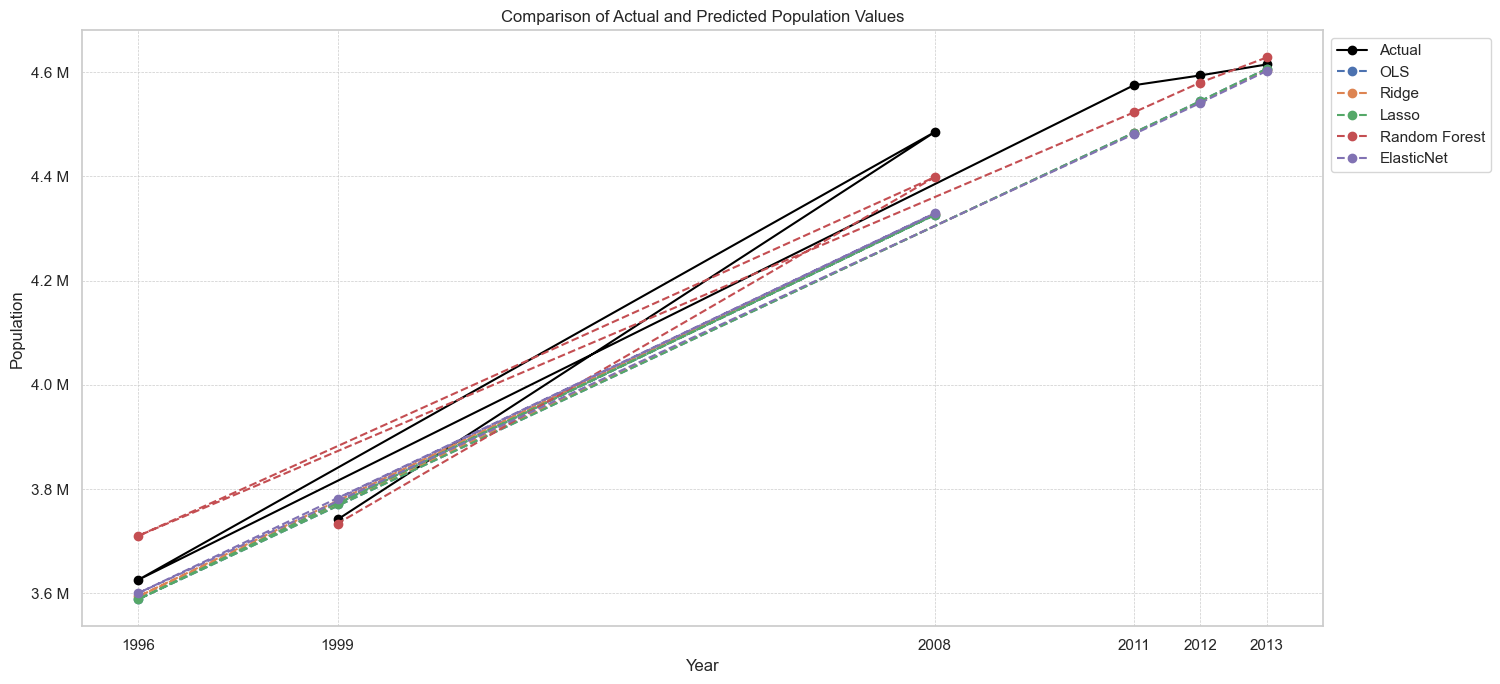

In [680]:
# Plotting the actual and predicted population values
plt.figure(figsize=(15, 7))

plt.plot(predictions_df['Year'], predictions_df['Actual'], label='Actual', color='black', marker='o')

plt.plot(predictions_df['Year'], predictions_df['OLS'], label='OLS', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['Ridge'], label='Ridge', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['Lasso'], label='Lasso', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['Random_Forest'], label='Random Forest', linestyle='--', marker='o')
plt.plot(predictions_df['Year'], predictions_df['ElasticNet'], label='ElasticNet', linestyle='--', marker='o')

plt.title('Comparison of Actual and Predicted Population Values')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.xticks(predictions_df['Year'].values)
plt.tight_layout()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))

plt.show()

The plot above illustrates the actual population values compared with the predictions made by each model for the years in the test set. The solid black line represents the actual population, while the dashed lines represent the predictions from the various regression models. The visual comparison help us to understand how well each model is able to track the actual population trend.​

**Insights**
The actual population shows a steady increase over the years in the dataset.

**Model Performance:**

* **OLS, Ridge, Lasso, and ElasticNet** models show a relatively similar performance in terms of following the trend of the actual population. This indicates that despite the regularization terms in Ridge, Lasso, and ElasticNet, the linear nature of these models produces similar results.
* The **Random Forest** model exhibits a different pattern, with predictions that are consistently lower than the actual population figures and the other models predictions. This suggests that the Random Forest model might not have captured the trend in the data as effectively as the linear models. This could be due to not having enough features that capture the time series nature of the data.
  
**Consistency:**

* The linear models **OLS, Ridge, Lasso, ElasticNet** are consistent with each other but tend to underestimate the population in later years. This might be because the trend is not perfectly linear and there might be other factors influencing population growth that are not captured by the model features.
* The **Random Forest** model's predictions are consistent within its own trend but are quite off from the actual data, indicating it may have missed key time-related dependencies or interactions between features.
  
**Potential for Improvement:**

* The deviations between the predictions and actual figures suggest that there may be non-linear patterns or additional factors that affect the population growth that are not being accounted for by the current features in the models.
* Incorporating additional features that could impact population growth, such as economic indicators, fertility rates, mortality rates, or even age division, might improve model performance.
* Since we're dealing with time series data, using models that can capture temporal dynamics, such as ARIMA (Autoregressive Integrated Moving Average), SARIMA (Seasonal ARIMA), or LSTM (Long Short-Term Memory networks), could potentially provide more accurate predictions.\
**Unfortunately, these models cannot be applied with the data we currently have to provide us with the expected and more accurate predictions.**
  
**Projection to Future:**

* If we were to use these models to project future population, the current evidence suggests that the linear models would likely give similar trajectories, but the actual future population could be higher than predicted if recent trends continue.
* The **Random Forest** model would likely underestimate future population unless it's **retrained with additional data or more complex features** that better capture the underlying population dynamics.
In conclusion, while the linear models seem to perform adequately, **there is room for improvement**, especially in capturing non-linear trends and other potential influences on population growth. Advanced time series models or machine learning approaches that can handle sequences and external factors could provide better insights and predictions.

#### **To improve accuracy and enable the use of models like ARIMA and other machine learning approaches, such as classification, I'll be adding another dataset for the migration. This dataset will include age groups for emigration and immigration.**

### Lodind the new dataset

In [681]:
migration_df_age_group = pd.read_csv('PEA03.20231022T221016.csv')

#### The Migration dataset with age groups

In [682]:
migration_df_age_group.head(7)

,STATISTIC,STATISTIC Label,TLIST(A1),Year,C02076V03371,Age Group,C02199V02655,Sex,C02542V03077,Inward or Outward Flow,UNIT,VALUE
0,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,-,Both sexes,1,Net migration,Thousand,-23.0
1,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,-,Both sexes,4,Emigrants: All destinations,Thousand,40.2
2,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,-,Both sexes,5,Immigrants: All origins,Thousand,17.2
3,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,1,Male,1,Net migration,Thousand,NaN
4,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,1,Male,4,Emigrants: All destinations,Thousand,NaN
5,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,1,Male,5,Immigrants: All origins,Thousand,NaN
6,PEA03,Estimated Migration (Persons in April),1987,1987,-,All ages,2,Female,1,Net migration,Thousand,NaN


In [683]:
population_df.head(7)

,Year,Age category,Single Year of Age,Sex category,Sex,UNIT,VALUE
0,1996,-,All ages,-,Both sexes,Number,3626087
1,1996,-,All ages,1,Male,Number,1800232
2,1996,-,All ages,2,Female,Number,1825855
3,1996,200,Under 1 year,-,Both sexes,Number,48854
4,1996,200,Under 1 year,1,Male,Number,25231
5,1996,200,Under 1 year,2,Female,Number,23623
6,1996,001,1 year,-,Both sexes,Number,48574


### Data preparation

In [684]:
population_df = population_df.drop(['Age category'], axis=1)

populattion_df_age_groups_for_ml = population_df[(population_df['Single Year of Age'] != 'All ages') & (population_df['Year'] >= 1996) & (population_df['Sex'] != 'Both sexes')]
populattion_df_age_groups_for_ml['Single Year of Age'] = populattion_df_age_groups_for_ml['Single Year of Age'].str.extract(r'(\d+)').astype(int)

populattion_df_age_groups_for_ml.head(7)

,Year,Single Year of Age,Sex category,Sex,UNIT,VALUE
4,1996,1,1,Male,Number,25231
5,1996,1,2,Female,Number,23623
7,1996,1,1,Male,Number,24963
8,1996,1,2,Female,Number,23611
10,1996,2,1,Male,Number,25245
11,1996,2,2,Female,Number,23766
13,1996,3,1,Male,Number,26005


#### Defining the age grouping column

In [685]:
def age_group(age):
    if age <= 14:
        return '0 - 14 years'
    elif age <= 24:
        return '15 - 24 years'
    elif age <= 44:
        return '25 - 44 years'
    elif age <= 64:
        return '45 - 64 years'
    else:
        return '65 years and over'

populattion_df_age_groups_for_ml['Age Group'] = populattion_df_age_groups_for_ml['Single Year of Age'].apply(age_group)

populattion_df_age_groups_for_ml


,Year,Single Year of Age,Sex category,Sex,UNIT,VALUE,Age Group
4,1996,1,1,Male,Number,25231,0 - 14 years
5,1996,1,2,Female,Number,23623,0 - 14 years
7,1996,1,1,Male,Number,24963,0 - 14 years
8,1996,1,2,Female,Number,23611,0 - 14 years
10,1996,2,1,Male,Number,25245,0 - 14 years
...,...,...,...,...,...,...,...
8477,2023,97,2,Female,Number,821,65 years and over
8479,2023,98,1,Male,Number,197,65 years and over
8480,2023,98,2,Female,Number,632,65 years and over
8482,2023,99,1,Male,Number,352,65 years and over


In [686]:
populattion_df_age_groups_for_ml.drop(['Single Year of Age'], axis = 1)

populattion_grouped_by_year = populattion_df_age_groups_for_ml.groupby(['Year', 'Age Group', 'Sex'])['VALUE'].sum().reset_index()

populattion_grouped_by_year

,Year,Age Group,Sex,VALUE
0,1996,0 - 14 years,Female,417972
1,1996,0 - 14 years,Male,441452
2,1996,15 - 24 years,Female,309797
3,1996,15 - 24 years,Male,323093
4,1996,25 - 44 years,Female,512789
...,...,...,...,...
275,2023,25 - 44 years,Male,708172
276,2023,45 - 64 years,Female,677223
277,2023,45 - 64 years,Male,661516
278,2023,65 years and over,Female,426368


In [687]:
migration_df_age_group = migration_df_age_group.drop(['STATISTIC', 'TLIST(A1)', 'C02076V03371','C02199V02655','C02542V03077'  ], axis=1)

migration_df_age_group_for_ml = migration_df_age_group[(migration_df_age_group['Age Group'] != 'All ages') & (migration_df_age_group['Year'] > 1995) & (migration_df_age_group['Sex'] != 'Both sexes')]

In [688]:
migration_df_age_group_for_ml.head(10)

,STATISTIC Label,Year,Age Group,Sex,Inward or Outward Flow,UNIT,VALUE
498,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Net migration,Thousand,NaN
499,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Emigrants: All destinations,Thousand,0.4
500,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Immigrants: All origins,Thousand,3.1
501,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Net migration,Thousand,NaN
502,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Emigrants: All destinations,Thousand,0.6
503,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Immigrants: All origins,Thousand,3.6
507,Estimated Migration (Persons in April),1996,15 - 24 years,Male,Net migration,Thousand,NaN
508,Estimated Migration (Persons in April),1996,15 - 24 years,Male,Emigrants: All destinations,Thousand,9.8
509,Estimated Migration (Persons in April),1996,15 - 24 years,Male,Immigrants: All origins,Thousand,4.2
510,Estimated Migration (Persons in April),1996,15 - 24 years,Female,Net migration,Thousand,NaN


In [689]:
migration_df_age_group_for_ml.isna().sum()

STATISTIC Label            0
Year                       0
Age Group                  0
Sex                        0
Inward or Outward Flow     0
UNIT                       0
VALUE                     60
dtype: int64

We have some missing values for the net migration. However, the net migration is the difference between immigrants and emigrants, so this can be easily calculated and thos values can be imputated. 

In [690]:
def calculate_net_migration(group):
    immigrants = group[group['Inward or Outward Flow'] == 'Immigrants: All origins']['VALUE'].values[0]
    emigrants = group[group['Inward or Outward Flow'] == 'Emigrants: All destinations']['VALUE'].values[0]
    net_migration = immigrants - emigrants
    group.loc[group['Inward or Outward Flow'] == 'Net migration', 'VALUE'] = net_migration
    return group

# Apply the function to each group
migration_df_age_group_for_ml = migration_df_age_group_for_ml.groupby(['Year', 'Age Group', 'Sex']).apply(calculate_net_migration).reset_index(drop=True)

# Display the updated dataframe to verify the imputation
migration_df_age_group_for_ml.head(7)

,STATISTIC Label,Year,Age Group,Sex,Inward or Outward Flow,UNIT,VALUE
0,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Net migration,Thousand,3.0
1,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Emigrants: All destinations,Thousand,0.6
2,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Immigrants: All origins,Thousand,3.6
3,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Net migration,Thousand,2.7
4,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Emigrants: All destinations,Thousand,0.4
5,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Immigrants: All origins,Thousand,3.1
6,Estimated Migration (Persons in April),1996,15 - 24 years,Female,Net migration,Thousand,-5.0


Converting to VALUE so that it can match the VALUE unit from the population

In [691]:
migration_df_age_group_for_ml['VALUE'] = migration_df_age_group_for_ml['VALUE'] * 1000

In [692]:
migration_df_age_group_for_ml.head(7)

,STATISTIC Label,Year,Age Group,Sex,Inward or Outward Flow,UNIT,VALUE
0,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Net migration,Thousand,3000.0
1,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Emigrants: All destinations,Thousand,600.0
2,Estimated Migration (Persons in April),1996,0 - 14 years,Female,Immigrants: All origins,Thousand,3600.0
3,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Net migration,Thousand,2700.0
4,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Emigrants: All destinations,Thousand,400.0
5,Estimated Migration (Persons in April),1996,0 - 14 years,Male,Immigrants: All origins,Thousand,3100.0
6,Estimated Migration (Persons in April),1996,15 - 24 years,Female,Net migration,Thousand,-5000.0


#### Merging already aligned datasets with right merge

In [693]:
merged_df = pd.merge(populattion_grouped_by_year, migration_df_age_group_for_ml, on=['Year', 'Age Group', 'Sex'], how='right')

df_merged_final = merged_df.drop('UNIT', axis=1)

In [694]:
df_merged_final.head(10)

,Year,Age Group,Sex,VALUE_x,STATISTIC Label,Inward or Outward Flow,VALUE_y
0,1996,0 - 14 years,Female,417972,Estimated Migration (Persons in April),Net migration,3000.0
1,1996,0 - 14 years,Female,417972,Estimated Migration (Persons in April),Emigrants: All destinations,600.0
2,1996,0 - 14 years,Female,417972,Estimated Migration (Persons in April),Immigrants: All origins,3600.0
3,1996,0 - 14 years,Male,441452,Estimated Migration (Persons in April),Net migration,2700.0
4,1996,0 - 14 years,Male,441452,Estimated Migration (Persons in April),Emigrants: All destinations,400.0
5,1996,0 - 14 years,Male,441452,Estimated Migration (Persons in April),Immigrants: All origins,3100.0
6,1996,15 - 24 years,Female,309797,Estimated Migration (Persons in April),Net migration,-5000.0
7,1996,15 - 24 years,Female,309797,Estimated Migration (Persons in April),Emigrants: All destinations,11700.0
8,1996,15 - 24 years,Female,309797,Estimated Migration (Persons in April),Immigrants: All origins,6700.0
9,1996,15 - 24 years,Male,323093,Estimated Migration (Persons in April),Net migration,-5600.0


In [695]:
pivot_df = df_merged_final.pivot_table(
    index=['Year', 'Age Group', 'Sex', 'VALUE_x'], 
    columns='Inward or Outward Flow', 
    values='VALUE_y', 
    aggfunc='first'  # Since we assume there is only one value for each type and group
).reset_index()

pivot_df.head()

Inward or Outward Flow,Year,Age Group,Sex,VALUE_x,Emigrants: All destinations,Immigrants: All origins,Net migration
0,1996,0 - 14 years,Female,417972,600.0,3600.0,3000.0
1,1996,0 - 14 years,Male,441452,400.0,3100.0,2700.0
2,1996,15 - 24 years,Female,309797,11700.0,6700.0,-5000.0
3,1996,15 - 24 years,Male,323093,9800.0,4200.0,-5600.0
4,1996,25 - 44 years,Female,512789,3000.0,8100.0,5100.0


Rename the merged columns for clarity

In [696]:
# Rename the columns for clarity
pivot_df.columns.name = None  # Remove the name of the columns' level
pivot_df = pivot_df.rename(columns={
    "Emigrants: All destinations": "Emigrants_All_Destinations",
    "Immigrants: All origins": "Immigrants_All_Origins",
    "Net migration": "Net_Migration",
    "VALUE_x": 'Population'
})

pivot_df.head()

,Year,Age Group,Sex,Population,Emigrants_All_Destinations,Immigrants_All_Origins,Net_Migration
0,1996,0 - 14 years,Female,417972,600.0,3600.0,3000.0
1,1996,0 - 14 years,Male,441452,400.0,3100.0,2700.0
2,1996,15 - 24 years,Female,309797,11700.0,6700.0,-5000.0
3,1996,15 - 24 years,Male,323093,9800.0,4200.0,-5600.0
4,1996,25 - 44 years,Female,512789,3000.0,8100.0,5100.0


In [697]:
pivot_df['Migration_Rate'] = (pivot_df['Net_Migration'] / pivot_df['Population']) * 1000

population_migration_df = pivot_df

population_migration_df.head(7)

,Year,Age Group,Sex,Population,Emigrants_All_Destinations,Immigrants_All_Origins,Net_Migration,Migration_Rate
0,1996,0 - 14 years,Female,417972,600.0,3600.0,3000.0,7.177514
1,1996,0 - 14 years,Male,441452,400.0,3100.0,2700.0,6.116180
2,1996,15 - 24 years,Female,309797,11700.0,6700.0,-5000.0,-16.139601
3,1996,15 - 24 years,Male,323093,9800.0,4200.0,-5600.0,-17.332471
4,1996,25 - 44 years,Female,512789,3000.0,8100.0,5100.0,9.945611
5,1996,25 - 44 years,Male,503302,5100.0,8700.0,3600.0,7.152763
6,1996,45 - 64 years,Female,348667,700.0,1300.0,600.0,1.720840


### Data preparation for machine learning models

Converting categorical variables to numerical variables using one-hot encoding

In [698]:
population_migration_df_encoded = pd.get_dummies(population_migration_df, columns=['Age Group', 'Sex'])

population_migration_df_encoded


,Year,Population,Emigrants_All_Destinations,Immigrants_All_Origins,Net_Migration,Migration_Rate,Age Group_0 - 14 years,Age Group_15 - 24 years,Age Group_25 - 44 years,Age Group_45 - 64 years,Age Group_65 years and over,Sex_Female,Sex_Male
0,1996,417972,600.0,3600.0,3000.0,7.177514,True,False,False,False,False,True,False
1,1996,441452,400.0,3100.0,2700.0,6.116180,True,False,False,False,False,False,True
2,1996,309797,11700.0,6700.0,-5000.0,-16.139601,False,True,False,False,False,True,False
3,1996,323093,9800.0,4200.0,-5600.0,-17.332471,False,True,False,False,False,False,True
4,1996,512789,3000.0,8100.0,5100.0,9.945611,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,2023,708172,17200.0,36800.0,19600.0,27.676892,False,False,True,False,False,False,True
276,2023,677223,2200.0,10300.0,8100.0,11.960610,False,False,False,True,False,True,False
277,2023,661516,3000.0,6600.0,3600.0,5.442045,False,False,False,True,False,False,True
278,2023,426368,600.0,2500.0,1900.0,4.456244,False,False,False,False,True,True,False


Converting categorical variables into a numerical format is essential for machine learning algorithms because they can only interpret and perform calculations with numbers. The process of converting categorical data into a numerical format is known as "encoding."

The **one-hot encoding** is a common method for encoding categorical variables. \

* **Binary Representation** One-hot encoding converts each category level into a new binary column (0s and 1s). This is particularly useful because it does not impose any ordinal relationship between the categories. For example, in the 'Sex' column with categories 'Male' and 'Female', we don't want the model to assume that 'Male' is greater or less than 'Female'. One-hot encoding avoids this by creating two separate columns, one for each gender, and marking '1' for presence and '0' for absence.

* **Model Interpretability**: After one-hot encoding, each category becomes a feature that either occurs (1) or does not occur (0), making it easier to interpret the impact of each category on the model's predictions.

* **Algorithm Compatibility**: Many machine learning algorithms, especially linear models, assume input features to be numerical and have meaningful distances between them. One-hot encoding allows these algorithms to use categorical data without making incorrect assumptions about the data's nature.

**One-hot encoding** can significantly increase the dataset's dimensionality if the categorical variable has many levels (known as the "curse of dimensionality").

For my dataset, since 'Age Group' and 'Sex' do not have a large number of categories, one-hot encoding is suitable and won't lead to an excessively large feature space.

After applying **one-hot encoding** to the categorical variables 'Age Group' and 'Sex', the resulting dataset will have additional columns for each category within those variables. Each original categorical value gets its own column, where each row is marked as either 1 (True) or 0 (False).

* **Binary Indicator Columns**: Each new column serves as an indicator for the presence of a category. For instance, if there are three age groups in the 'Age Group' column, one-hot encoding will create three new columns, one for each age group. A row will have a '1' in the column of the age group it belongs to and '0's in the others. This binary system is why the values are filled with True (1) or False (0).

* **Eliminating Ordinality**: The original 'Age Group' and 'Sex' columns might be misinterpreted by the machine learning algorithms as having some sort of ordinal or hierarchical relationship, where one category might be considered "higher" or "more" than another. This is not the case with categories like 'Sex' or 'Age Group'. By using one-hot encoding, we create a flat, non-ordinal structure where each category is equal in weight but distinct.

This binary representation allows the model to clearly distinguish between the presence and absence of each category without any ambiguity or implied order.

In [699]:
X = population_migration_df_encoded.drop('Population', axis=1)
y = population_migration_df_encoded['Population']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

data_preparation_summary = {
    'original_shape': population_migration_df.shape,
    'encoded_shape': population_migration_df_encoded.shape,
    'features_shape': X.shape,
    'target_shape': y.shape,
    'X_train_shape': X_train.shape,
    'X_test_shape': X_test.shape,
    'y_train_shape': y_train.shape,
    'y_test_shape': y_test.shape
}

data_preparation_summary

{'original_shape': (280, 8),
 'encoded_shape': (280, 13),
 'features_shape': (280, 12),
 'target_shape': (280,),
 'X_train_shape': (224, 12),
 'X_test_shape': (56, 12),
 'y_train_shape': (224,),
 'y_test_shape': (56,)}

### Exploratory Data Analysis (EDA)

Exploring the data further could provide insights that might improve model performance or inform feature.\
Reviewing the distribution of various features could help in understanding the underlying patterns, detecting outliers, or discovering data imbalances.\
Further exploration can help you ensure the quality of the data by detecting anomalies or errors that could adversely affect the model.

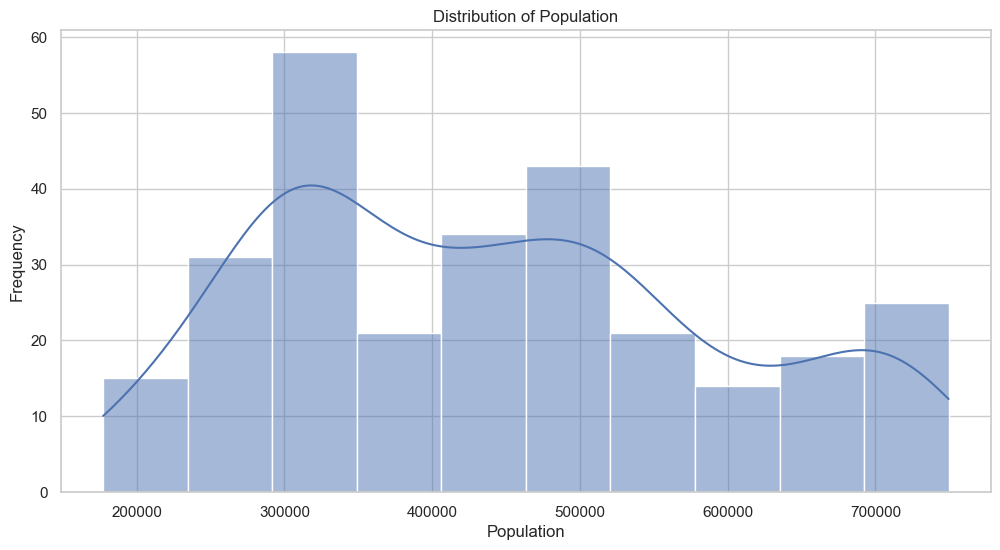

In [700]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Plotting the distribution of the target variable 'Population'
plt.figure(figsize=(12, 6))
sns.histplot(population_migration_df['Population'], kde=True)
plt.title('Distribution of Population')
plt.xlabel('Population')
plt.ylabel('Frequency')
plt.show()



The histogram of the 'Population' variable suggests that the population data might be right-skewed, indicating that there are age groups that have a relatively low population size, and these age groups appear more frequently in the data.

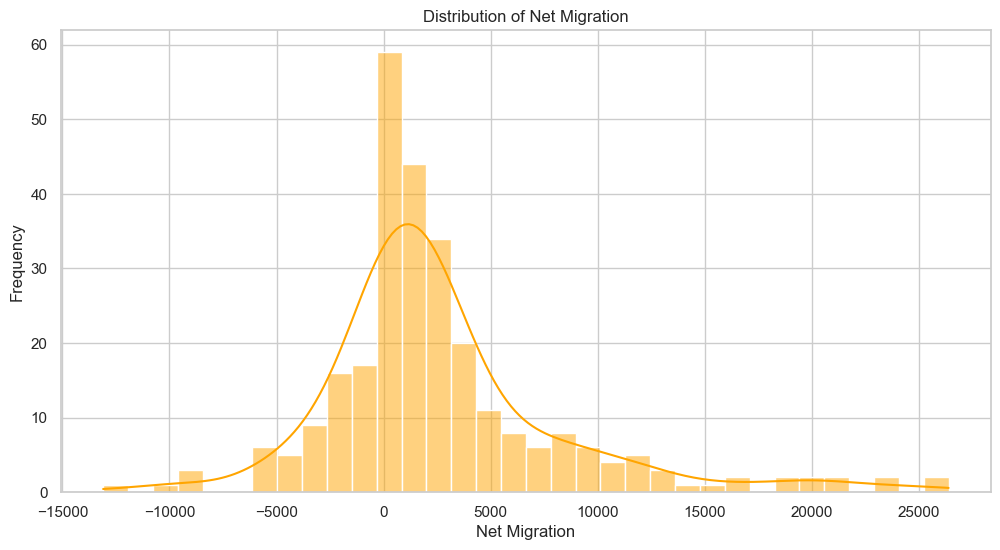

In [701]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Plotting the distribution of 'Net_Migration'
plt.figure(figsize=(12, 6))
sns.histplot(population_migration_df['Net_Migration'], kde=True, color='orange')
plt.title('Distribution of Net Migration')
plt.xlabel('Net Migration')
plt.ylabel('Frequency')
plt.show()


The net migration distribution also appears to be right-skewed, with a concentration of values around the lower end of the scale, suggesting that high net migration values are less common.

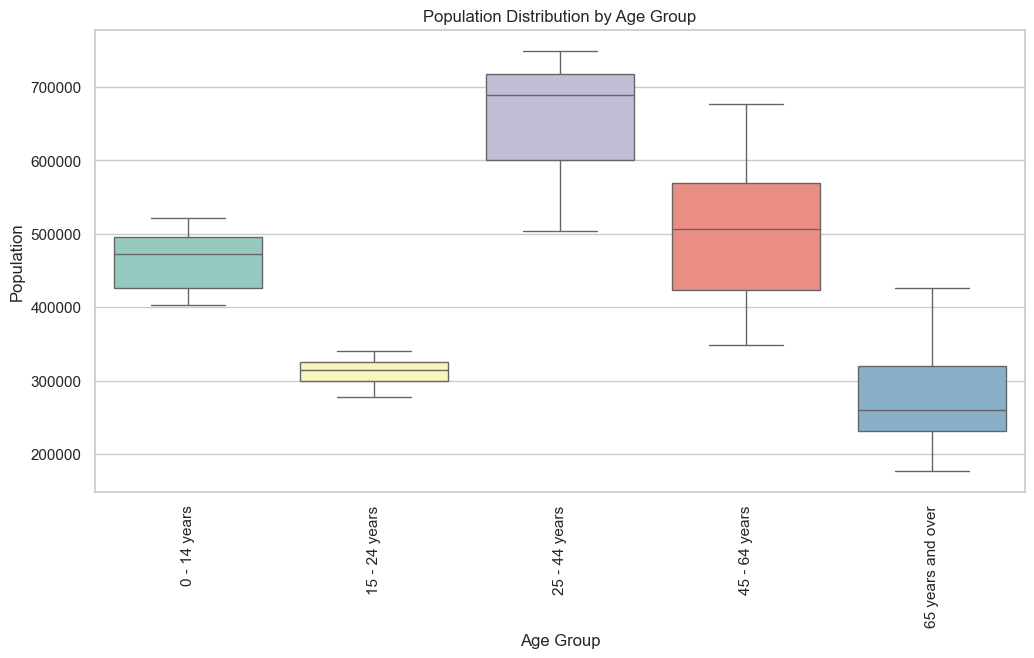

In [702]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Boxplot to visualize the distribution of 'Population' across different 'Age Group'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Age Group', y='Population', data=population_migration_df, palette='Set3')
plt.title('Population Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Population')
plt.xticks(rotation=90)
plt.show()


The boxplot grouped by 'Age Group' shows the spread of population figures within each age category. It appears that some age groups have a wider range of population figures, and potentially a few outliers.

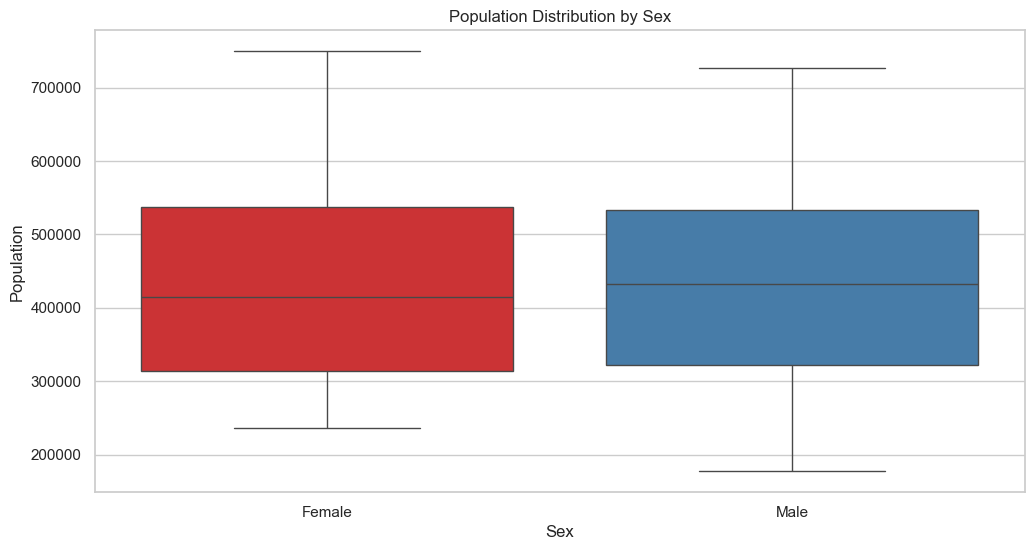

In [703]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

# Boxplot to visualize the distribution of 'Population' across different 'Sex'
plt.figure(figsize=(12, 6))
sns.boxplot(x='Sex', y='Population', data=population_migration_df, palette='Set1')
plt.title('Population Distribution by Sex')
plt.xlabel('Sex')
plt.ylabel('Population')
plt.show()

The boxplot grouped by 'Sex' indicates that the median population is quite similar between different sexes, though there are outliers in both categories.

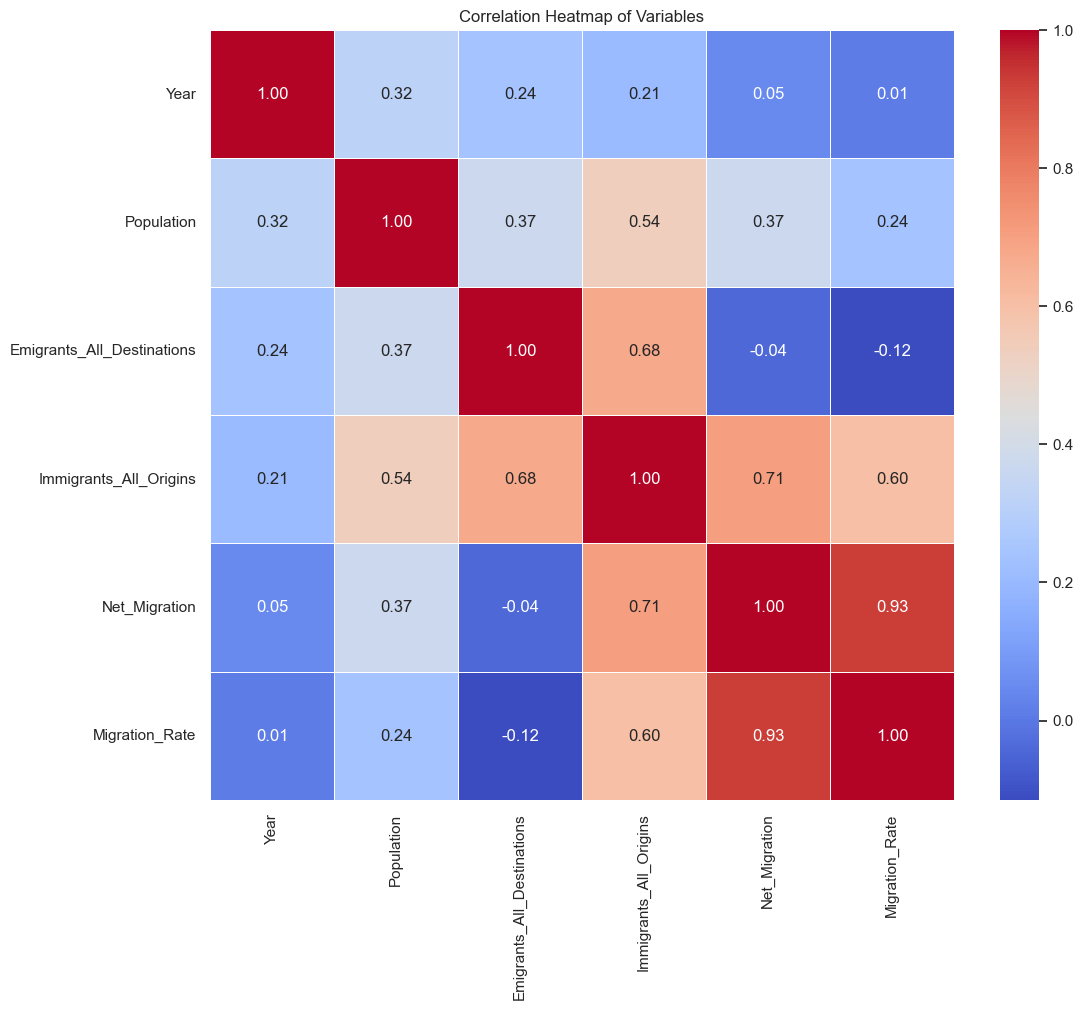

In [704]:
# Setting the aesthetics for the plots
sns.set(style="whitegrid")

numeric_df = population_migration_df.drop(['Age Group', 'Sex'], axis=1)
correlation_matrix = numeric_df.corr()

# Correlation heatmap to understand the relationship between variables
plt.figure(figsize=(12, 10))
sns.set(font_scale=1)  # Adjust the font size
sns.set_style("white")  # Set the style
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Variables')
plt.show()

The correlation heatmap of the variables shows how each variable is related to the others. For instance, a high positive correlation between two variables suggests they increase together, while a high negative correlation indicates an inverse relationship.

### Working with ML models

#### OLS Regression

In [705]:
# Initialize the Linear Regression model (OLS)
ols_model = LinearRegression()

# Train the model
ols_model.fit(X_train, y_train)

# Predict on the testing set
y_pred_ols = ols_model.predict(X_test)

# Calculate performance metrics for OLS regression
ols_r2 = r2_score(y_test, y_pred_ols)
ols_mae = mean_absolute_error(y_test, y_pred_ols)
ols_mse = mean_squared_error(y_test, y_pred_ols)
ols_rmse = sqrt(ols_mse)

ols_metrics = {
    'R2': ols_r2,
    'MSE': ols_mse,
    'RMSE': ols_rmse,
    'MAE': ols_mae
}

ols_metrics


{'R2': 0.9300904934152554,
 'MSE': 1535238973.4342284,
 'RMSE': 39182.125688051034,
 'MAE': 32442.01178994359}

In [706]:
bool_columns = ['Age Group_0 - 14 years', 'Age Group_15 - 24 years', 'Age Group_25 - 44 years', 'Age Group_45 - 64 years', 'Age Group_65 years and over', 'Sex_Female', 'Sex_Male']

# Add a constant term to the features for OLS Regression
X_train_ols = sm.add_constant(X_train)
X_train_ols[bool_columns] = X_train_ols[bool_columns].astype(int)
# Fit the OLS Regression model
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Summary of the OLS model
ols_model_summary = ols_model.summary()

# Print the summary
print(ols_model_summary)


                            OLS Regression Results                            
Dep. Variable:             Population   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     379.5
Date:                Thu, 09 Nov 2023   Prob (F-statistic):          2.68e-126
Time:                        03:05:23   Log-Likelihood:                -2675.7
No. Observations:                 224   AIC:                             5371.
Df Residuals:                     214   BIC:                             5406.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

**R-squared (R²)**: is a measure of how well the model explains the variance in the population data. In this case, the OLS model has an R-squared value of 0.941, which is quite high. It suggests that approximately 94.1% of the variance in the population data is explained by the model. This indicates a strong fit of the model to the data.

**Adjusted R-squared (Adj. R²)**: adjusts the R-squared value based on the number of predictors in the model. It provides a more conservative estimate of model fit. The adjusted R-squared value here is 0.939, which is also high, indicating that the model is not overfitting.

**Coefficients**: coefficients (coef) for each predictor variable represent the estimated impact of that variable on the population. For example, the coefficient for the 'Year' variable is 4709.0990, which means that for each additional year, the population is estimated to increase by approximately 4709.

**P-values**: associated with the coefficients indicate whether each predictor variable is statistically significant in predicting the population. Smaller p-values (typically less than 0.05) suggest that the variable is significant. In this case, most predictor variables have very small p-values, indicating their significance.

**Intercept (const)**: represents the estimated population when all predictor variables are zero. In this case, it's a large negative value, which is not meaningful on its own but is adjusted by the other variables.

**F-statistic and Prob (F-statistic)**: used to test the overall significance of the model. A small p-value for the F-statistic (typically less than 0.05) suggests that the model is significant. In this case, the p-value is very small, indicating the model's overall significance.

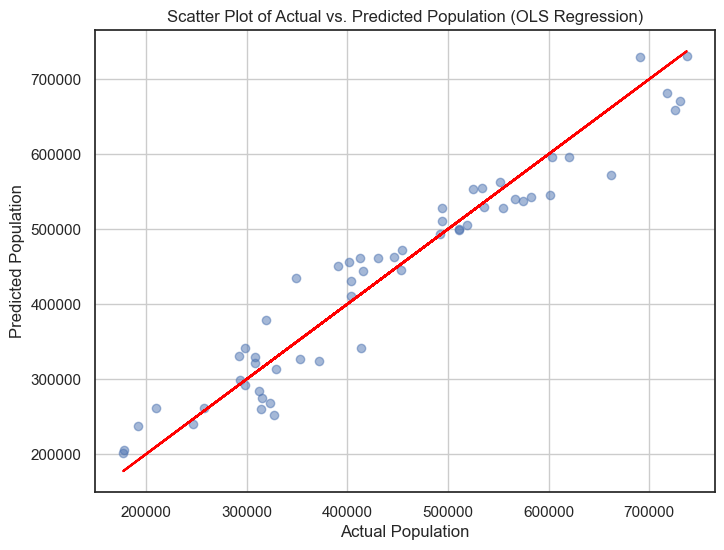

In [707]:
# Predict population values using the OLS model
X_test_ols = sm.add_constant(X_test)
X_test_ols[bool_columns] = X_test_ols[bool_columns].astype(int)
y_pred_ols = ols_model.predict(X_test_ols)

# Create a scatter plot of predicted vs. actual values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ols, alpha=0.5)
plt.plot(y_test, y_test, color='red')  # Adding a reference line
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.title("Scatter Plot of Actual vs. Predicted Population (OLS Regression)")
plt.grid(True)

# Show the plot
plt.show()


The scatter plot above shows the relationship between the actual population values from the test set and the population values predicted by the OLS regression model. A perfect prediction would result in all points lying on a 45-degree line, as that would indicate that for every point, the predicted value equals the actual value.**The red line** represents the ideal case where predicted values match the actual values perfectly. In this plot, while not all points lie on this line, there appears to be a strong positive correlation between the predicted and actual values, which is also supported by the high R-squared value we saw earlier.

In summary, the OLS Regression model appears to be a strong fit for the population data, with a high R-squared value and most predictor variables showing statistical significance. The scatter plot of actual vs. predicted values also suggests that the model's predictions align well with the actual population values.

### Lasso & Ridge Regression, Elastic Net, Random Forest
(using GridSearchCV hyperparameter tuning)

In [708]:
lasso = Lasso(random_state=42)
ridge = Ridge(random_state=42)
elastic_net = ElasticNet(random_state=42)
random_forest = RandomForestRegressor(random_state=42)

# Define the hyperparameter grid for each model
lasso_params = {'alpha': [0.01, 0.1, 1, 10]}
ridge_params = {'alpha': [0.01, 0.1, 1, 10]}
elastic_net_params = {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.2, 0.5, 0.8]}
rf_params = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4]
}

grid_lasso = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2', n_jobs=-1)
grid_ridge = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2', n_jobs=-1)
grid_elastic_net = GridSearchCV(elastic_net, elastic_net_params, cv=5, scoring='r2', n_jobs=-1)
grid_random_forest = GridSearchCV(random_forest, rf_params, cv=5, scoring='r2', n_jobs=-1)

grid_lasso.fit(X_train, y_train)
grid_ridge.fit(X_train, y_train)
grid_elastic_net.fit(X_train, y_train)
grid_random_forest.fit(X_train, y_train)

best_lasso = grid_lasso.best_estimator_
best_ridge = grid_ridge.best_estimator_
best_elastic_net = grid_elastic_net.best_estimator_
best_random_forest = grid_random_forest.best_estimator_

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    return {'R2': r2, 'MSE': mse, 'RMSE': rmse, 'MAE': mae}

lasso_metrics = evaluate_model(best_lasso, X_test, y_test)
ridge_metrics = evaluate_model(best_ridge, X_test, y_test)
elastic_net_metrics = evaluate_model(best_elastic_net, X_test, y_test)
random_forest_metrics = evaluate_model(best_random_forest, X_test, y_test)

metrics_summary = {
    'OLS': ols_metrics,
    'Lasso': lasso_metrics,
    'Ridge': ridge_metrics,
    'ElasticNet': elastic_net_metrics,
    'RandomForest': random_forest_metrics
}

metrics_summary


{'OLS': {'R2': 0.9300904934152554,
  'MSE': 1535238973.4342284,
  'RMSE': 39182.125688051034,
  'MAE': 32442.01178994359},
 'Lasso': {'R2': 0.9300921729607003,
  'MSE': 1535202089.9866016,
  'RMSE': 39181.65501847263,
  'MAE': 32445.47251605359},
 'Ridge': {'R2': 0.9288170985882853,
  'MSE': 1563203201.225826,
  'RMSE': 39537.36462165664,
  'MAE': 32698.21662862017},
 'ElasticNet': {'R2': 0.9286023496900185,
  'MSE': 1567919167.5403874,
  'RMSE': 39596.95906935768,
  'MAE': 32726.618050536075},
 'RandomForest': {'R2': 0.9908883720081167,
  'MSE': 200094766.6197071,
  'RMSE': 14145.485732901048,
  'MAE': 9901.625714285716}}

#### Models comparison

**OLS** (Ordinary Least Squares) Regression:
* MAE: 32442.01
* RMSE: 39182.13
* MSE: 1535238973.43
* R²: 0.9301
  
**Lasso** Regression (with hyperparameter tuning):
* MAE: 32445.47
* RMSE: 39181.66
* MSE: 1535202089.99
* R²: 0.9301
* 
**Ridge** Regression (with hyperparameter tuning):
* MAE: 32698.22
* RMSE: 39537.36
* MSE: 1563203201.23
* R²: 0.9288
  
**ElasticNet** Regression (with hyperparameter tuning):
* MAE: 32726.62
* RMSE: 39596.96
* MSE: 1567919167.54
* R²: 0.9286
  
**Random Forest** Regression (with hyperparameter tuning):
* MAE: 9901.63
* RMSE: 14145.49
* MSE: 200094766.62
* R²: 0.9909

* The Random Forest model significantly outperforms the linear models in terms of all metrics, with a very high R² value of 0.9909 and the lowest error scores. This suggests that the Random Forest model has a better fit to the data than the linear models.

* The regularized regression models show a slight improvement or comparable performance to the OLS model, which is expected as they are more robust to multicollinearity and can handle overfitting better due to their regularization terms.

* The convergence warnings for ElasticNet suggest that the model optimization process did not converge, which means that the result might not be the best possible solution.

#### Actual vs Predict population plots

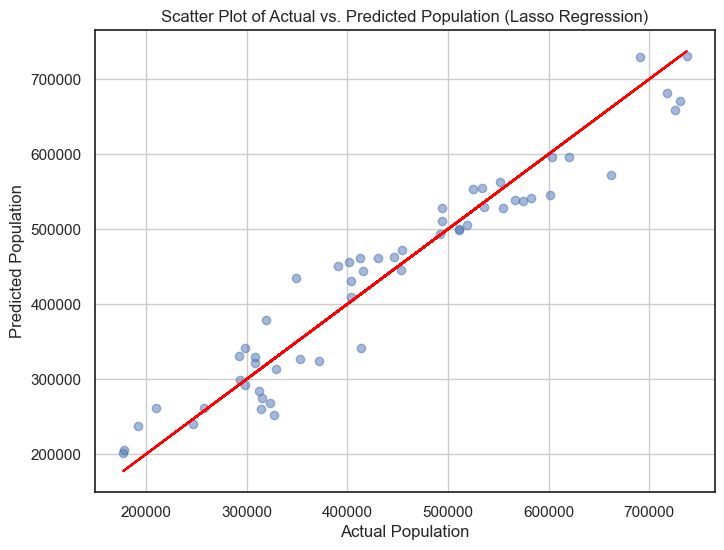

In [709]:

best_lasso = grid_lasso.best_estimator_
y_pred_lasso = best_lasso.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.plot(y_test, y_test, color='red')
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.title("Scatter Plot of Actual vs. Predicted Population (Lasso Regression)")
plt.grid(True)
plt.show()

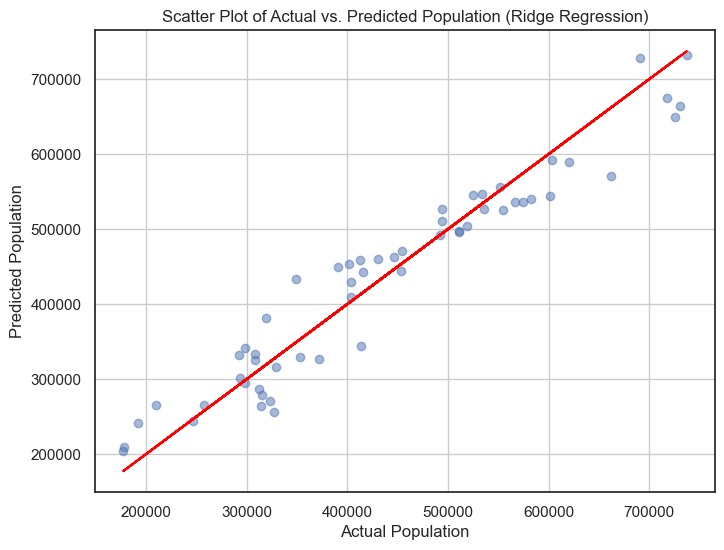

In [710]:
y_pred_ridge = best_ridge.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.plot(y_test, y_test, color='red')
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.title("Scatter Plot of Actual vs. Predicted Population (Ridge Regression)")
plt.grid(True)
plt.show()


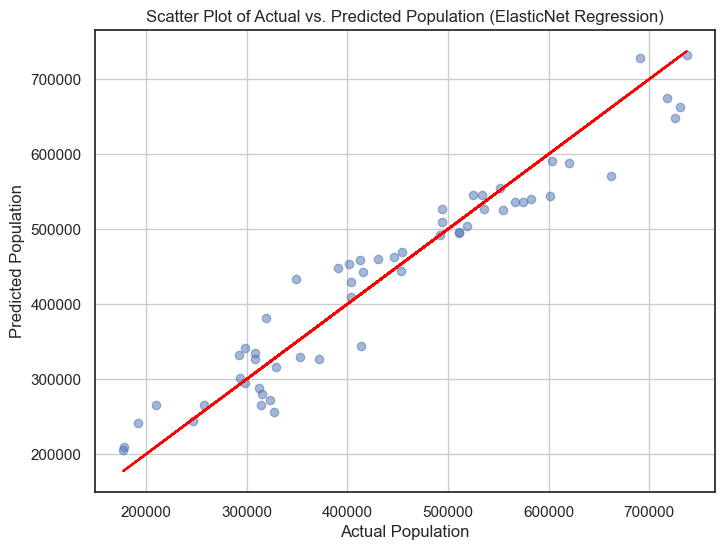

In [711]:
y_pred_elastic_net = best_elastic_net.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_elastic_net, alpha=0.5)
plt.plot(y_test, y_test, color='red')
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.title("Scatter Plot of Actual vs. Predicted Population (ElasticNet Regression)")
plt.grid(True)
plt.show()


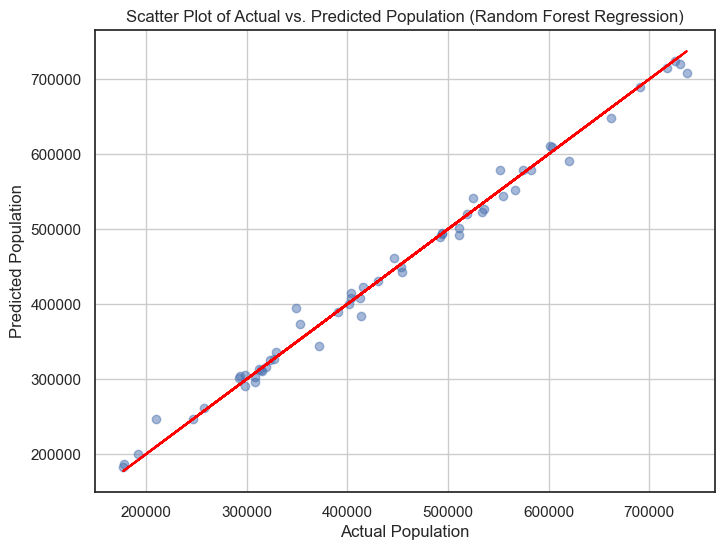

In [712]:
y_pred_random_forest = best_random_forest.predict(X_test)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_random_forest, alpha=0.5)
plt.plot(y_test, y_test, color='red')
plt.xlabel("Actual Population")
plt.ylabel("Predicted Population")
plt.title("Scatter Plot of Actual vs. Predicted Population (Random Forest Regression)")
plt.grid(True)
plt.show()


### Final comparison

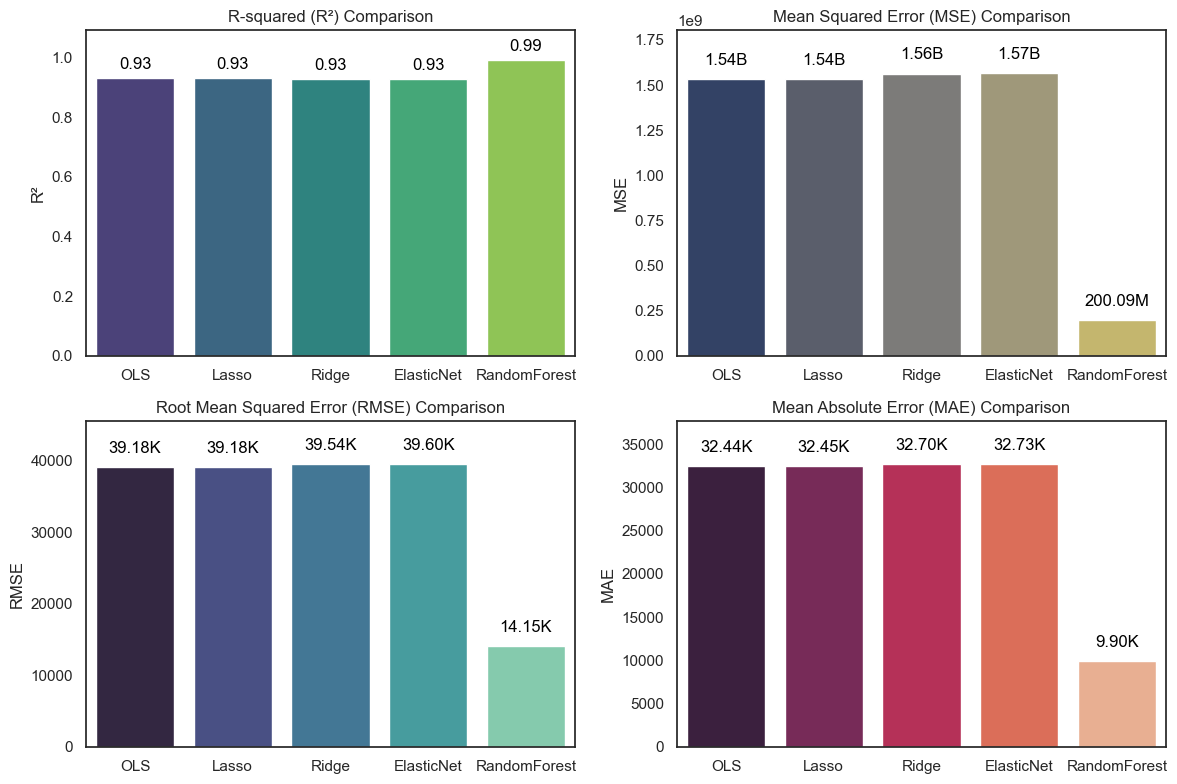

In [713]:
model_names = list(metrics_summary.keys())
r2_values = [metrics['R2'] for metrics in metrics_summary.values()]
mse_values = [metrics['MSE'] for metrics in metrics_summary.values()]
rmse_values = [metrics['RMSE'] for metrics in metrics_summary.values()]
mae_values = [metrics['MAE'] for metrics in metrics_summary.values()]

def format_metric(value):
    if value < 1e3:
        return f"{value:.2f}"
    elif value < 1e6:
        return f"{value/1e3:.2f}K"
    elif value < 1e9:
        return f"{value/1e6:.2f}M"
    else:
        return f"{value/1e9:.2f}B"

fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

# R-squared comparison
sns.barplot(ax=axs[0], x=model_names, y=r2_values, palette="viridis")
axs[0].set_title('R-squared (R²) Comparison')
axs[0].set_ylabel('R²')
axs[0].set_ylim(0, max(r2_values) + 0.1)  # Adding space above the bars
for i, v in enumerate(r2_values):
    axs[0].text(i, v + 0.03, f"{v:.2f}", color='black', ha='center')

# MSE comparison
sns.barplot(ax=axs[1], x=model_names, y=mse_values, palette="cividis")
axs[1].set_title('Mean Squared Error (MSE) Comparison')
axs[1].set_ylabel('MSE')
axs[1].set_ylim(0, max(mse_values) * 1.15)  # Adding space above the bars
for i, v in enumerate(mse_values):
    axs[1].text(i, v + max(mse_values)*0.05, format_metric(v), color='black', ha='center')

# RMSE comparison
sns.barplot(ax=axs[2], x=model_names, y=rmse_values, palette="mako")
axs[2].set_title('Root Mean Squared Error (RMSE) Comparison')
axs[2].set_ylabel('RMSE')
axs[2].set_ylim(0, max(rmse_values) * 1.15)  # Adding space above the bars
for i, v in enumerate(rmse_values):
    axs[2].text(i, v + max(rmse_values)*0.05, format_metric(v), color='black', ha='center')

# MAE comparison
sns.barplot(ax=axs[3], x=model_names, y=mae_values, palette="rocket")
axs[3].set_title('Mean Absolute Error (MAE) Comparison')
axs[3].set_ylabel('MAE')
axs[3].set_ylim(0, max(mae_values) * 1.15)  # Adding space above the bars
for i, v in enumerate(mae_values):
    axs[3].text(i, v + max(mae_values)*0.05, format_metric(v), color='black', ha='center')

plt.tight_layout()
plt.show()



### ARIMA

In [714]:
population_per_year = population_migration_df.groupby('Year')['Population'].sum()

population_per_year.index = pd.to_datetime(population_per_year.index, format='%Y')

train_size = int(len(population_per_year) * 0.8)
train, test = population_per_year[0:train_size], population_per_year[train_size:]

arima_model = ARIMA(train, order=(1, 1, 1))
arima_model_fit = arima_model.fit()

forecast = arima_model_fit.forecast(steps=len(test))

arima_mse = mean_squared_error(test, forecast)
arima_rmse = sqrt(arima_mse)

metrics_summary['ARIMA'] = {'MSE': arima_mse, 'RMSE': arima_rmse}

metrics_summary['ARIMA']

{'MSE': 9326273363.51829, 'RMSE': 96572.63258044844}

The MSE is quite high, which suggests that the model's forecasts are, on average, a significant distance away from the actual values in the test set. The RMSE, being the square root of MSE, also indicates a similar discrepancy.

##### Fine-tuning of ARIMA model parameters, using grid search to systematically explore different combinations of p, d, and q values. 

In [715]:
p = d = q = range(0, 3)

pdq = list(itertools.product(p, d, q))

arima_metrics = {}

import warnings
warnings.filterwarnings("ignore")

for param in pdq:
    try:
        arima_model = ARIMA(train, order=param)
        arima_model_fit = arima_model.fit()

        forecast = arima_model_fit.forecast(steps=len(test))

        arima_mse = mean_squared_error(test, forecast)
        arima_rmse = sqrt(arima_mse)

        arima_metrics[param] = {'MSE': arima_mse, 'RMSE': arima_rmse}
    except:
        continue

best_params = min(arima_metrics, key=lambda x: arima_metrics[x]['MSE'])
best_arima_result = arima_metrics[best_params]

best_arima_result, best_params

({'MSE': 409045172.7530702, 'RMSE': 20224.865209762713}, (2, 2, 1))

After running a simplified grid search to tune the parameters of the ARIMA model, the best-performing model was ARIMA(2,2,1). ARIMA(2,2,1) model achieved a significantly lower Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) compared to the initial ARIMA(1,1,1) model, indicating a better fit. These results suggest that the time series data likely has a second-order differencing pattern and a first-order moving average process, which the ARIMA(2,2,1) is able to capture. In terms of forecasting capability, ARIMA(2,2,1) model would be expected to perform better than the initial ARIMA(1,1,1).

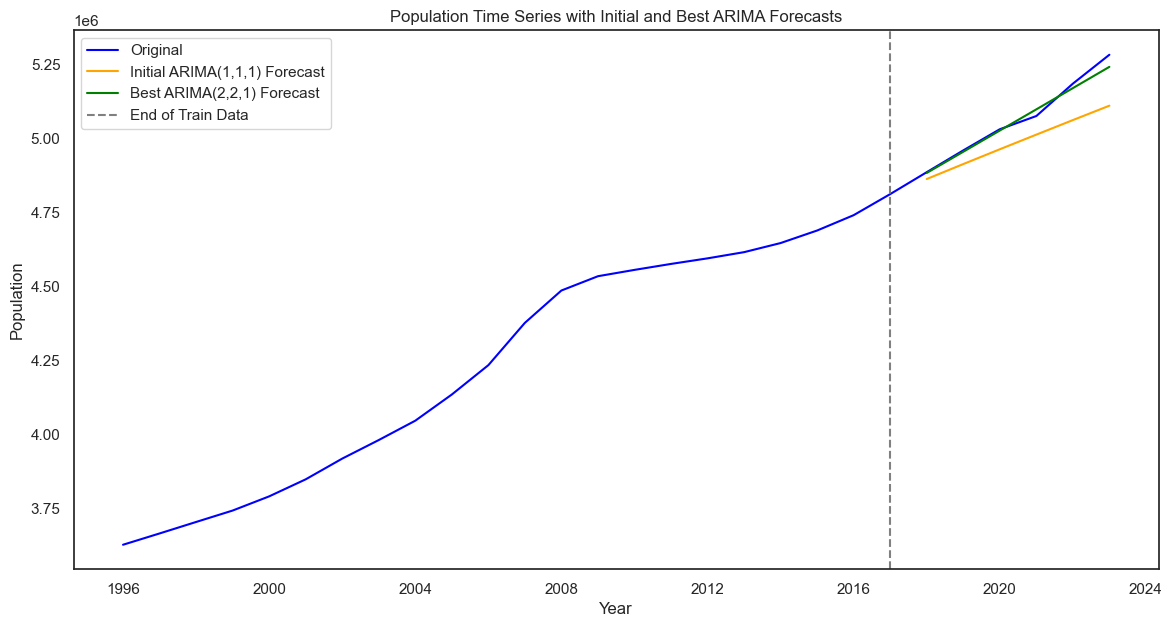

In [716]:
best_arima_model = ARIMA(train, order=best_params)
best_arima_model_fit = best_arima_model.fit()

best_forecast = best_arima_model_fit.forecast(steps=len(test))

plt.figure(figsize=(14,7))
plt.plot(population_per_year.index, population_per_year, label='Original', color='blue')

initial_arima_model = ARIMA(train, order=(1, 1, 1))
initial_arima_model_fit = initial_arima_model.fit()
initial_forecast = initial_arima_model_fit.forecast(steps=len(test))
plt.plot(test.index, initial_forecast, label='Initial ARIMA(1,1,1) Forecast', color='orange')

plt.plot(test.index, best_forecast, label='Best ARIMA(2,2,1) Forecast', color='green')

plt.axvline(x=train.index[-1], linestyle='--', color='grey', label='End of Train Data')

plt.title('Population Time Series with Initial and Best ARIMA Forecasts')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.show()


* The blue line represents the actual population data over time.
* The orange line shows the forecast from the initial ARIMA(1,1,1) model.
* The green line indicates the forecast from the best ARIMA(2,2,1) model after parameter tuning.
* The grey dashed line marks the end of the training data and the beginning of the testing period where the models' forecasts are compared against the actual data.

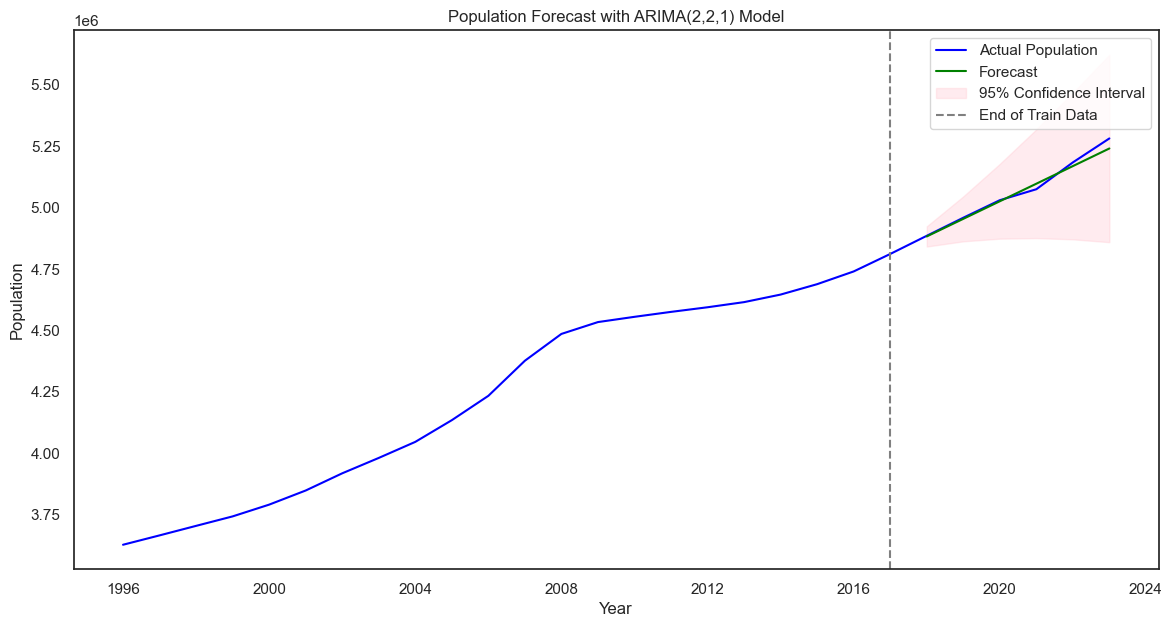

In [717]:
forecast_results = best_arima_model_fit.get_forecast(steps=len(test))
forecast_values = forecast_results.predicted_mean
conf_int = forecast_results.conf_int()

plt.figure(figsize=(14,7))
plt.plot(population_per_year.index, population_per_year, label='Actual Population', color='blue')

plt.plot(test.index, forecast_values, label='Forecast', color='green')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3, label='95% Confidence Interval')

plt.axvline(x=train.index[-1], linestyle='--', color='grey', label='End of Train Data')

plt.title('Population Forecast with ARIMA(2,2,1) Model')
plt.xlabel('Year')
plt.ylabel('Population')
plt.legend()
plt.show()


**The pink shaded area** represents the 95% confidence interval for the forecast, providing a range where future points are expected to fall with 95% certainty.

### **Classification for Predicting Emigration**

**Predicting population** would typically be a regression task since the target variable (population size) is continuous.\
However, in this case, I'll approach emigration prediction as a binary classification problem using Logistic Regression, Support Vector Machine, Random Forest, Gradient Boosting

In [718]:
data = population_migration_df

X = data.drop('Migration_Rate', axis=1)
y = pd.qcut(data['Migration_Rate'], q=3, labels=["low", "medium", "high"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['Year', 'Population', 'Emigrants_All_Destinations', 'Immigrants_All_Origins', 'Net_Migration']
numerical_transformer = StandardScaler()

categorical_features = ['Age Group', 'Sex']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42)
}

#### Confusion matrix and Model accuracity

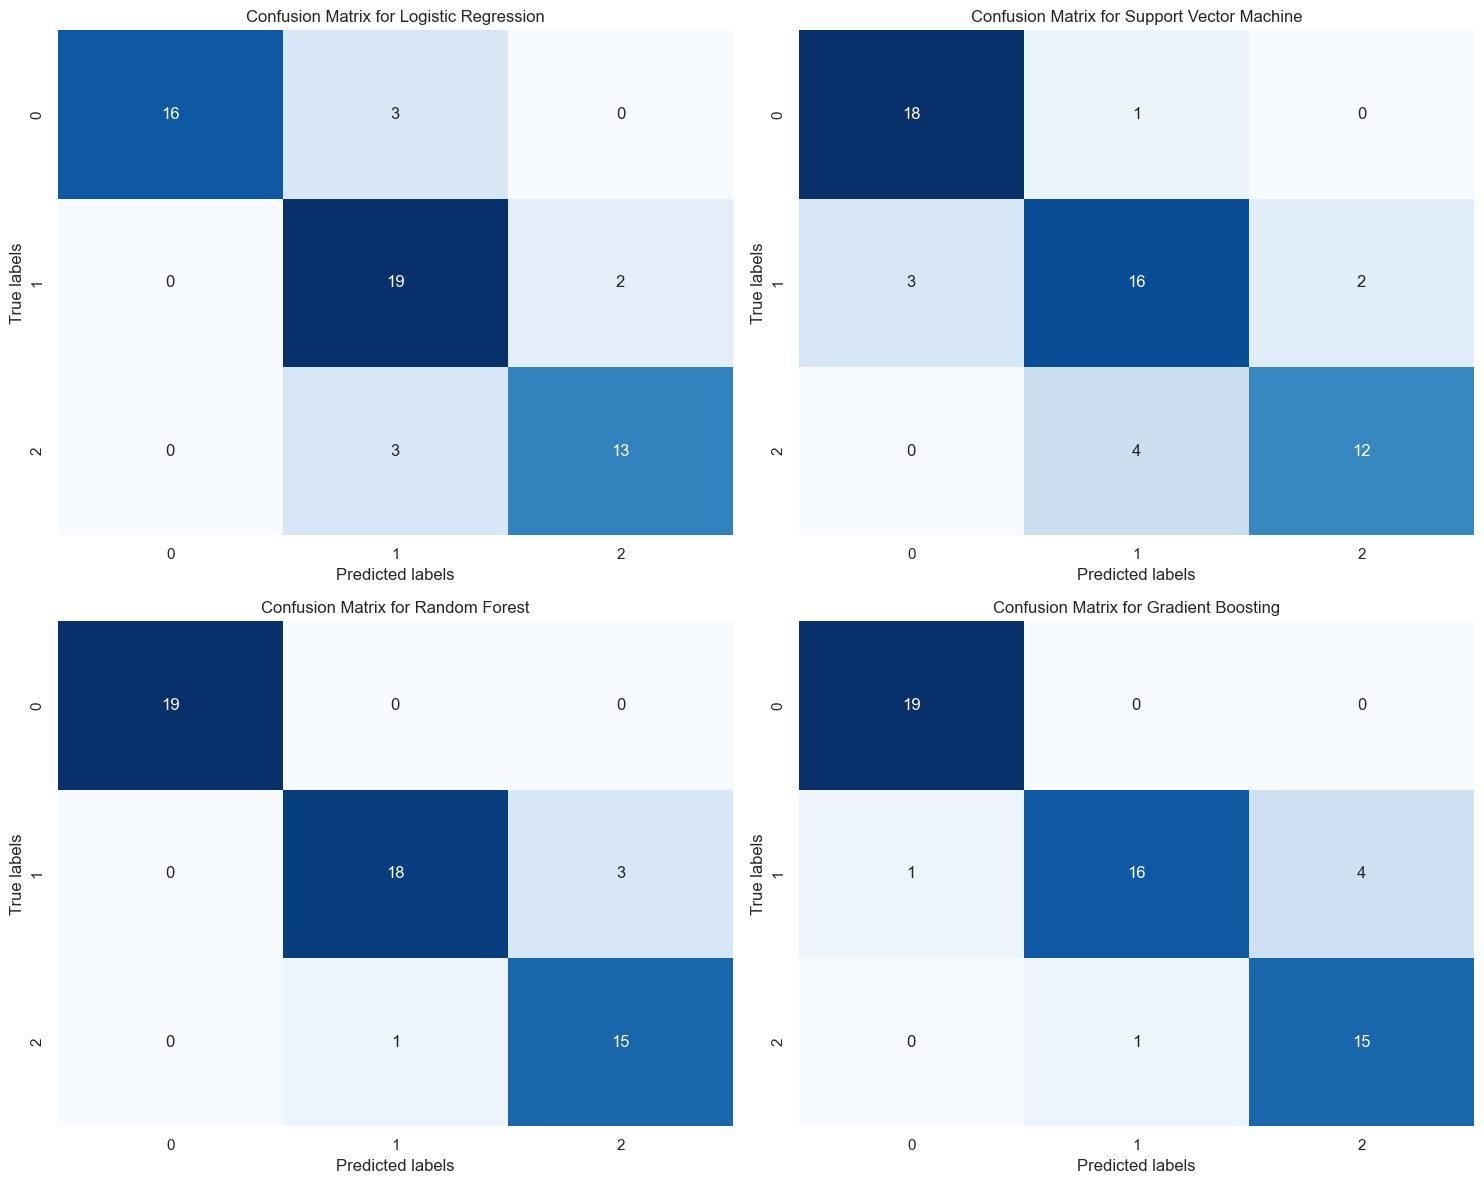

{'Logistic Regression': 0.8571428571428571,
 'Support Vector Machine': 0.8214285714285714,
 'Random Forest': 0.9285714285714286,
 'Gradient Boosting': 0.8928571428571429}

In [719]:
def evaluate_and_plot_models(models, X_train, y_train, X_test, y_test, preprocessor):
    results = {}
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    for idx, (name, model) in enumerate(models.items()):        
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', model)])
        
        pipeline.fit(X_train, y_train)
        
        y_pred = pipeline.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        classification_rep = classification_report(y_test, y_pred)
        
        conf_matrix = confusion_matrix(y_test, y_pred, labels=["low", "medium", "high"])
        
        sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', ax=axes[idx], cbar=False)
        axes[idx].set_title(f'Confusion Matrix for {name}')
        axes[idx].set_xlabel('Predicted labels')
        axes[idx].set_ylabel('True labels')
        
        results[name] = {
            'accuracy': accuracy,
            'classification_report': classification_rep,
            'confusion_matrix': conf_matrix
        }
    
    plt.tight_layout()
    plt.show()
    
    return results

model_results = evaluate_and_plot_models(models, X_train, y_train, X_test, y_test, preprocessor)
model_accuracies = {name: result['accuracy'] for name, result in model_results.items()}
model_accuracies

#### **Accuracy scores per model based on the test set evaluation:**
* Logistic Regression: 85.7%
* Support Vector Machine: 82.1%
* Random Forest: 92.9%
* Gradient Boosting: 89.3%

In [720]:
logreg_report = model_results['Logistic Regression']['classification_report']
print("Logistic Regression Classification Report:\n")
print(logreg_report)

Logistic Regression Classification Report:

              precision    recall  f1-score   support

        high       0.87      0.81      0.84        16
         low       1.00      0.84      0.91        19
      medium       0.76      0.90      0.83        21

    accuracy                           0.86        56
   macro avg       0.88      0.85      0.86        56
weighted avg       0.87      0.86      0.86        56



In [721]:
svm_report = model_results['Support Vector Machine']['classification_report']
print("\nSupport Vector Machine Classification Report:\n")
print(svm_report)


Support Vector Machine Classification Report:

              precision    recall  f1-score   support

        high       0.86      0.75      0.80        16
         low       0.86      0.95      0.90        19
      medium       0.76      0.76      0.76        21

    accuracy                           0.82        56
   macro avg       0.83      0.82      0.82        56
weighted avg       0.82      0.82      0.82        56



In [722]:
rf_report = model_results['Random Forest']['classification_report']
print("\nRandom Forest Classification Report:\n")
print(rf_report)


Random Forest Classification Report:

              precision    recall  f1-score   support

        high       0.83      0.94      0.88        16
         low       1.00      1.00      1.00        19
      medium       0.95      0.86      0.90        21

    accuracy                           0.93        56
   macro avg       0.93      0.93      0.93        56
weighted avg       0.93      0.93      0.93        56



In [723]:
gb_report = model_results['Gradient Boosting']['classification_report']
print("\nGradient Boosting Classification Report:\n")
print(gb_report)


Gradient Boosting Classification Report:

              precision    recall  f1-score   support

        high       0.79      0.94      0.86        16
         low       0.95      1.00      0.97        19
      medium       0.94      0.76      0.84        21

    accuracy                           0.89        56
   macro avg       0.89      0.90      0.89        56
weighted avg       0.90      0.89      0.89        56



* Precision: Indicates the ratio of correctly predicted positive observations to the total predicted positives.
* Recall: Indicates the ratio of correctly predicted positive observations to the all observations in actual class
* F1-score: The weighted harmonic mean of precision and recall. The highest value is 1 and the lowest is 0. F1-score is more useful than accuracy, especially if you have an uneven class distribution.

#### Feature importance graphs for the Logistic Regression, Random Forest, and Gradient Boosting models

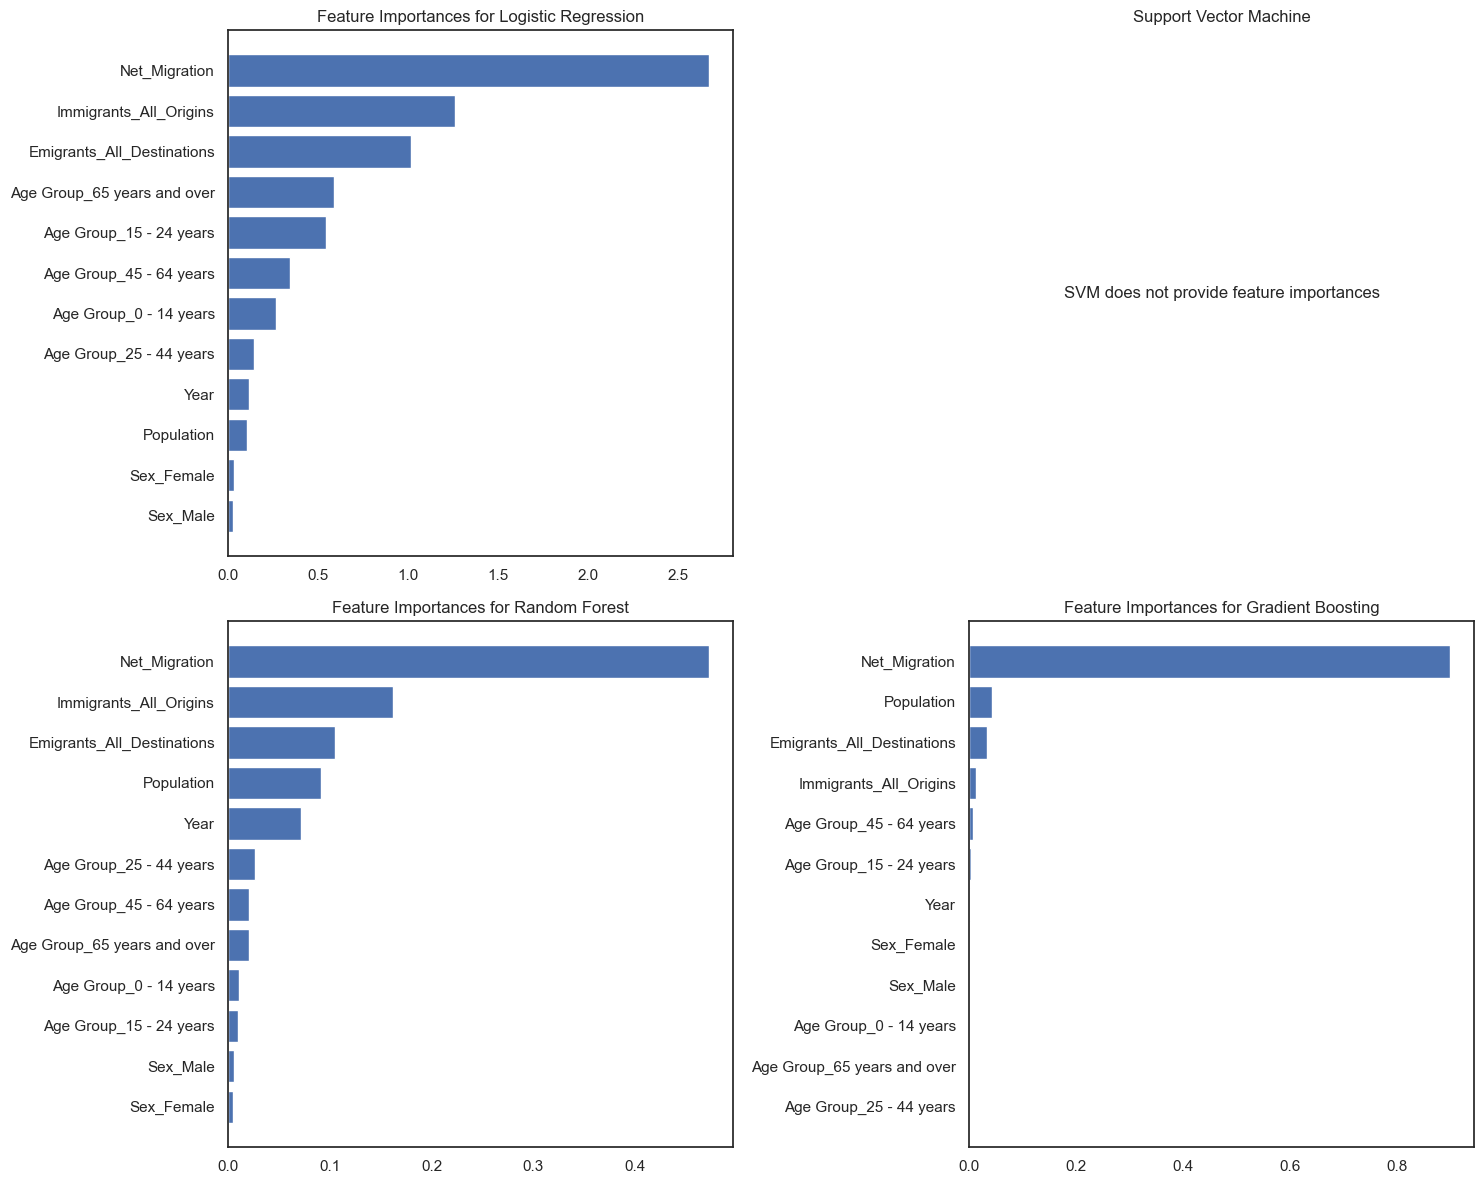

In [724]:
def plot_feature_importances(models, X_train, preprocessor):
    feature_names_transformed = preprocessor.transformers_[1][1].get_feature_names_out(categorical_features)
    all_feature_names = np.concatenate([numerical_features, feature_names_transformed])

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models.items()):
        if name == "Support Vector Machine":
            axes[idx].text(0.5, 0.5, 'SVM does not provide feature importances',
                           verticalalignment='center', horizontalalignment='center',
                           transform=axes[idx].transAxes, fontsize=12)
            axes[idx].set_title(name)
            axes[idx].axis('off')
            continue
        
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('model', model)])
        pipeline.fit(X_train, y_train)

        if name in ["Random Forest", "Gradient Boosting"]:
            importances = pipeline.named_steps['model'].feature_importances_
        elif name == "Logistic Regression":
            importances = np.mean(np.abs(pipeline.named_steps['model'].coef_), axis=0)
        
        indices = np.argsort(importances)
        
        axes[idx].barh(range(len(indices)), importances[indices], align='center')
        axes[idx].set_yticks(range(len(indices)))
        axes[idx].set_yticklabels(all_feature_names[indices])
        axes[idx].set_title(f'Feature Importances for {name}')
    
    plt.tight_layout()
    plt.show()
    
plot_feature_importances(models, X_train, preprocessor)


* For the Logistic Regression model, the feature importances are represented by the average absolute values of the coefficients across all classes. 
* For the Random Forest and Gradient Boosting models, the importances are based on the impurity decrease brought by each feature.
* Support Vector Machine (SVM) model does not inherently provide a feature importance measure, which is why its graph is omitted.
  
These graphs provide insights into which features are most influential for each model when making predictions. Features at the top of each graph are the most important, and those at the bottom are the least important.